In [2]:
from scipy.sparse.construct import random
%matplotlib inline
import numpy as np 
import matplotlib.pyplot as plt #plotting routine
import scipy as sp
import scipy.stats as stats
from scipy.integrate import odeint
from scipy.interpolate import CubicHermiteSpline
from scipy.interpolate import BSpline
import math
from sklearn.model_selection import train_test_split
from localreg import *
from skfda.representation.basis import BSpline
import time


In [21]:
'''
Logistic function

t -- time series

'''
def P(t):
    return K / (1 + np.math.exp(-r*t))

"""
Logistic differential equation

t -- time series
r -- valus of the groth rate E.coli per day for feed codition
K -- valus of the carrying capacity of E.coli Colony Forming Units(CFU)/g for feed codition

returns df(x)/dt 
"""
def logisticEquation(t,r,K):

    def model(P,t):
        return r*P*(1-P/K)

    return odeint(model, x0, t)[:,0]

''' 
Calculates the Standard Error 

r -- vector with the residuals
'''
def S(r):
    return np.sqrt(np.sum(np.square(r))/(len(r)-2))


''' 
Calsulates R squared (Coefficient of Determination)

y -- vector with target values
p -- vector with rrediction values
'''
def R2(y, p):
    mean = np.mean(y)
    SST = np.sum(np.power(y-mean,2))
    SSR = np.sum(np.power(p-mean,2))
    SSE = np.sum(np.power(y-p,2))
    
    return 1 - SSR / SST

Data generation from the logistic function with gaussian noise for a E.coli bacteria colony with a carring capacity of 10^4 CFU/g and growth rate of 0.75

In [22]:
np.random.seed(15)
n = 250 #no of smaples
K = 10**4  # carrying capacity of E.coli Colony Forming Units(CFU)/g for feed codition
r = 0.75 # groth rate E.coli per day for feed codition
x0 = 10
t = np.linspace(0,20,n)
y = logisticEquation(t,r,K).flatten() # ODE solutions

trainingT, testingT = train_test_split(t, test_size= 100, train_size= 150, random_state=42)

trainingT = np.sort(trainingT)
trainingY = np.empty(150)

testingT = np.sort(testingT)
testingY = np.empty(100)
i = 0
j = 0
for l in range(len(t)):
    if(trainingT[i] == t[l]):
        trainingY[i] = y[l]
        i += 1
    else:
        testingY[j] = y[l]
        j += 1

noiseTraining = np.random.normal(0,500,150)
noisyY = trainingY + noiseTraining
noisyY[:50] = np.abs(noisyY[:50]) + 5

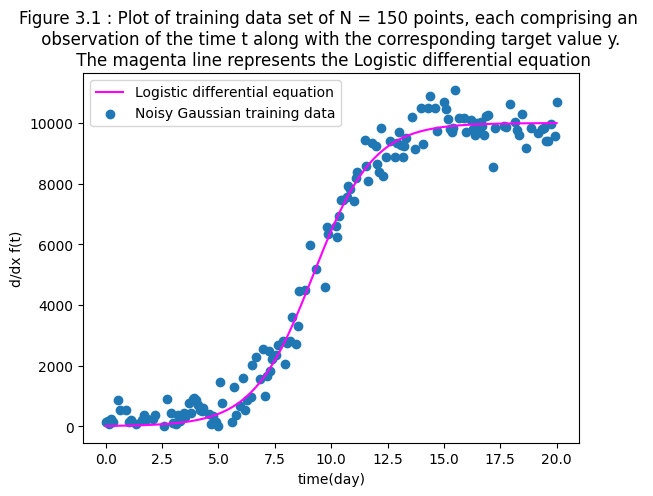

In [23]:
np.random.seed(15) 
plt.plot(t, y, label = "Logistic differential equation", c="magenta")
# plt.plot(trainingT, trainingY, label = "Logistic differential equation")
plt.scatter(trainingT, noisyY, label = 'Noisy Gaussian training data')
plt.title("Figure 3.1 : Plot of training data set of N = 150 points, each comprising an \n observation of the time t along with the corresponding target value y. \n The magenta line represents the Logistic differential equation")
plt.xlabel("time(day)")
plt.ylabel("d/dx f(t)")
plt.legend()

In [ ]:
# # Logistic function plots
fig=plt.figure(figsize=(8,5))
nk = 10
plt.scatter(trainingT,noisyY, label="Data",color="darkcyan", marker = 'x')
print("Target",K,r)
start= time.time()
estimations = LSFELG(trainingT, nk, [0,20], trainingY, noiseTraining)

e1,e2 = sp.optimize.curve_fit(logisticEquation, trainingT , estimations, full_output = 1)[0]
end = time.time()
print("Time LSFE:", end-start)
print("LSFE",e1,e2)
predictions1 = predict(trainingT,e1,e2)
plt.plot(trainingT,predictions1, label="LSFE", color = "darkviolet")
print(statis(trainingY,predictions1,noiseTraining))

e1,e2 = PsLS(trainingT, noisyY, logisticEquation, 1, rbf.epanechnikov, [e1,e2])
print("PsLSWithLSFE",e1,e2)
predictions = predict(trainingT,e1,e2)
plt.plot(trainingT,predictions, label="PsLS With LSFE", color = "firebrick", ls="--")
print(statis(trainingY,predictions,noiseTraining))


e1,e2 = PsLS(trainingT, noisyY, logisticEquation,1, rbf.epanechnikov)
print("PsLS",e1,e2)
predictions = predict(trainingT,e1,e2)
print(statis(trainingY,predictions,noiseTraining))
plt.plot(trainingT,predictions, label="PsLS",color="orange", ls="-.")

plt.legend()
plt.xlabel("Time (days)", fontsize=13)
plt.ylabel("Population", fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
fig.savefig('LG.png')

residualAnalysis(trainingT, noisyY, predictions1, noiseTraining, "Least Square Finite Elemetn residual analysis")
residualAnalysis(trainingT, noisyY, predictions, noiseTraining, "Pseudo-Least Squares residual analysis")

# 2017 KRUGER

In [28]:
from sklearn.preprocessing import SplineTransformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from scipy.interpolate import splrep
from scipy.interpolate import BSpline

# LSFE fuction using logistic regression
def LSFELG(t, nk, interval, trainingY, noiseTraining) : 
    
    start = time.time()
    a,b = interval
    
    
    while nk < 50:
        T , w = np.polynomial.legendre.leggauss(5*nk)
        W = np.diag(w) #weight matrix of the Gauss-Legendre quadrature
        T = (b-a)/2 * T + (b+a)/2 # shift values in to the right interval (from[-1, 1] to [a, b])
        model = make_pipeline(SplineTransformer(n_knots=nk, degree=2), Ridge(alpha=1e-3))
        y = logisticEquation(T,r,K)
        model.fit(T[:, np.newaxis],y[:, np.newaxis])
        predictions = model.predict(t[:, np.newaxis])[:,0]
        st = statis(trainingY,predictions,noiseTraining)
        
        if st[1] <= 50 and st[2] >= 0.8 :
#             print(nk , "\n", st)
            break

        nk += 1
    end = time.time()
    print(nk , "\n", st)
    
    return predictions

def LSFE1(t, X0, nk, interval, model) : 
    
    start = time.time()
    a,b = interval
    
    if b < 70:
        while nk<50:
            T , w = np.polynomial.legendre.leggauss(5*(nk-1))
            W = np.diag(w) #weight matrix of the Gauss-Legendre quadrature
            T = (b-a)/2 * T + (b+a)/2 # shift values in to the right interval (from[-1, 1] to [a, b])
            y = odeint(model, X0, T)[:,0]
            x_new = np.linspace(0, 1, nk+2)[1:-1]
            q_knots = np.quantile(T, x_new) 
            knots,c,k = splrep(T, y, t=q_knots, s=1, k=2, task=-1)
            f =  BSpline(knots,c,k)
            predictions = f(t)
            st = statis(y1-noise1,predictions,noise1)

            if st[1] <= 0.05 and st[2] >= 0.8 :
                break

            nk += 1
    else:
        while nk<50:
            
            T , w = np.polynomial.legendre.leggauss(5*(nk-1))
            W = np.diag(w) #weight matrix of the Gauss-Legendre quadrature
            T = (b-a)/2 * T + (b+a)/2
            y = odeint(model, X0, T)[:,0]
            x_new = np.linspace(0, 1, nk+2)[1:-1]
            q_knots = np.quantile(T, x_new) 
            knots,c,k = splrep(T, y, t=q_knots, s=1, k=2, task=-1)
            f =  BSpline(knots,c,k)
            predictions = f(t)
            st = statis(y2-noise2,predictions,noise2)

            if st[1] < 0.2 and st[2] > 0.7 :
                break

            nk += 1
    end = time.time()
    print("LSFE 1",nk)
    print(st)
    print("Time LSFE:", end-start)
    return predictions, f

def LSFE2(t, X0, nk, interval, model) : 

    start= time.time()
    a,b = interval
    
    if b < 70:
        while nk<50:
            T , w = np.polynomial.legendre.leggauss(5*(nk-1))
            W = np.diag(w) #weight matrix of the Gauss-Legendre quadrature
            T = (b-a)/2 * T + (b+a)/2 # shift values in to the right interval (from[-1, 1] to [a, b])
            y = odeint(model, X0, T)[:,1]
            x_new = np.linspace(0, 1, nk+2)[1:-1]
            q_knots = np.quantile(T, x_new) 
            knots,c,k = splrep(T, y, t=q_knots, s=1, k=2, task=-1)
            f =  BSpline(knots,c,k)
            predictions = f(t)
            st = statis(y2-noise2,predictions,noise2)

            if st[1] <= 0.05 and st[2] >= 0.8 :
                break

            nk += 1
    else:
        while nk<50:
            T , w = np.polynomial.legendre.leggauss(5*(nk-1))
            W = np.diag(w) #weight matrix of the Gauss-Legendre quadrature
            T = (b-a)/2 * T + (b+a)/2
            y = odeint(model, X0, T)[:,0]
            x_new = np.linspace(0, 1, nk+2)[1:-1]
            q_knots = np.quantile(T, x_new) 
            knots,c,k = splrep(T, y, t=q_knots, s=1, k=2, task=-1)
            f =  BSpline(knots,c,k)
            predictions = f(t)
            st = statis(y2-noise2,predictions,noise2)

            if st[1] < 0.2 and st[2] > 0.7 :
                break

            nk += 1
    end= time.time()
    print("LSFE 2",nk)
    print(st)
    print("Time LSFE:", end-start)
    return predictions, f


# Parameter Estimation for Differential Equation Models Using a Framework of Measurement Error in Regression Models

In [14]:

def predict(x, e1,e2):    
    return logisticEquation(x,e1,e2)

In [40]:
def PsLS(trainingT, y, model, degree, kernel, initialGuesses=None):
    start = time.time()
    smoothY = localreg(trainingT, y, degree = degree, kernel = kernel)
    deltaT = smoothY - y #error
    smoothY += deltaT
    if initialGuesses is None:
        minim = sp.optimize.curve_fit(model, trainingT , smoothY, full_output = 1)
    else:
        minim = sp.optimize.curve_fit(model, trainingT , smoothY, p0= initialGuesses, full_output = 1)
    end = time.time()
    print("Time PsLS:", end-start)
    return minim[0]


### Residual analysis

In [26]:
from sklearn.metrics import r2_score

''' 
Function that displays 3 graphs:

1st -- Predictions vs Residuals plot
2nd -- Predictions vs Observations plot
3rd -- Residual histogram
'''

def residualAnalysis (t, y, p, noise, name):
    
    residuals = y - p

    fig=plt.figure(figsize=(8,5))
    plt.suptitle(name)

# predictions vs results
    plt.scatter(p,residuals,color="darkcyan", marker = 'x')
    plt.plot(p,np.zeros(len(p)),color = "grey", ls='--')
    plt.xlabel("Predictions", fontsize=13)
    plt.ylabel("Residuals", fontsize=13)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    fig.savefig('R.png')
    plt.show()
    
# predictions vs observed
    fig=plt.figure(figsize=(8,5))
    plt.scatter(p,y, c= "darkcyan", marker = 'x')
    plt.plot([0,np.max(p)],[0,np.max(p)],color = "grey", ls='--')
    plt.title("Predictions vs Observations")
    plt.xlabel("Predictions", fontsize=13)
    plt.ylabel("Observations", fontsize=13)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    fig.savefig('O.png')
    plt.show()
    
# prediction histogram
    fig=plt.figure(figsize=(8,5))
    plt.hist(residuals, color="darkcyan")
    plt.title("Residual histogram")
    plt.xlabel("Residuals", fontsize=13)
    plt.ylabel("Freaquency", fontsize=13)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    fig.savefig('H.png')
    plt.show()

''' 
Calculates goodness-of-fit statistics

y -- vector with the target values
p -- vector with the predicted values
noise -- vector with the noise added to the target

returns :
    - S (Standard error)
    - R2 (R squared)
    - KS (Kolmogorov–Smirnov) test

'''
def statis(y, p, noise):
    
    residuals = y - p
    s = S(residuals)
    r2 = r2_score(y,p)
    
    ObRes=[signal-model for signal,model in zip(y+noise,p)]

    KS=stats.ks_2samp(ObRes,noise)

    return KS, s, r2

## Model comparison 
### FitzHugh-Nagumo equations
from the paper to check for right implemetnation

Predictions on the first equation

In [51]:
import ipywidgets as ipw

alpha = 0.34 #mortality rate due to predators
beta = 0.2
gamma = 3.
x10 = 0
x20 = 0.1


# MakeModel
def FHNModel(X0, alpha, beta, gamma):
    x1, x2 = X0
    dotx1 = (x1 + x2 - np.power(x1,3))*gamma
    dotx2 = -(x1 - alpha + beta*x2)/gamma
    return [dotx1, dotx2]
# ODEModel
def FHNSolutions(X0,t):
    
    return(FHNModel(X0, alpha, beta, gamma))

# soulutions = odeint(FHNSolutions, X0, t)

Nt = 201
b = 30
t = np.linspace(0.,b, Nt)
X0 = [x10, x20]
solutions = odeint(FHNSolutions, X0, t)
y1 = solutions[:,0]
y2 = solutions[:,1]
noise1 = np.random.normal(0,0.02, Nt)
y1 = y1 + noise1
# plt.plot(t,y1)
noise2 = np.random.normal(0,0.02, Nt)
y2 = y2 + noise2

# Fitting the model

def FHNSolver1(t,alpha,beta,gamma,X0):
    
    cAlpha=alpha
    cBeta=beta
    cGamma=gamma
    
    cX0=X0
    
    def LocalModel(cX0,t):
        
        return FHNModel(cX0, cAlpha,cBeta,cGamma)
    
    Solution=odeint(LocalModel,cX0,t)
    
    return Solution[:,0]

def FHNFit1(t,alpha,beta,gamma):
    
    return FHNSolver1(t,alpha,beta,gamma,X0)

Predicgtion on the second equation

In [46]:
def FHNSolver2(t,alpha,beta,gamma,X0):
    
    cAlpha=alpha
    cBeta=beta
    cGamma=gamma
    
    cX0=X0
    
    def LocalModel(cX0,t):
        
        return FHNModel(cX0, cAlpha, cBeta, cGamma)
    
    Solution=odeint(LocalModel,cX0,t)
    
    return Solution[:,1]

def FHNFit2(t,alpha,beta,gamma):
    
    return FHNSolver2(t,alpha,beta,gamma,X0)


0.34 0.2 3.0
LSFE 1 43
(KstestResult(statistic=0.14925373134328357, pvalue=0.02259571794572208), 0.04907540440502924, 0.9959484558632429)
Time LSFE: 0.572702169418335


NameError: name 'X01' is not defined

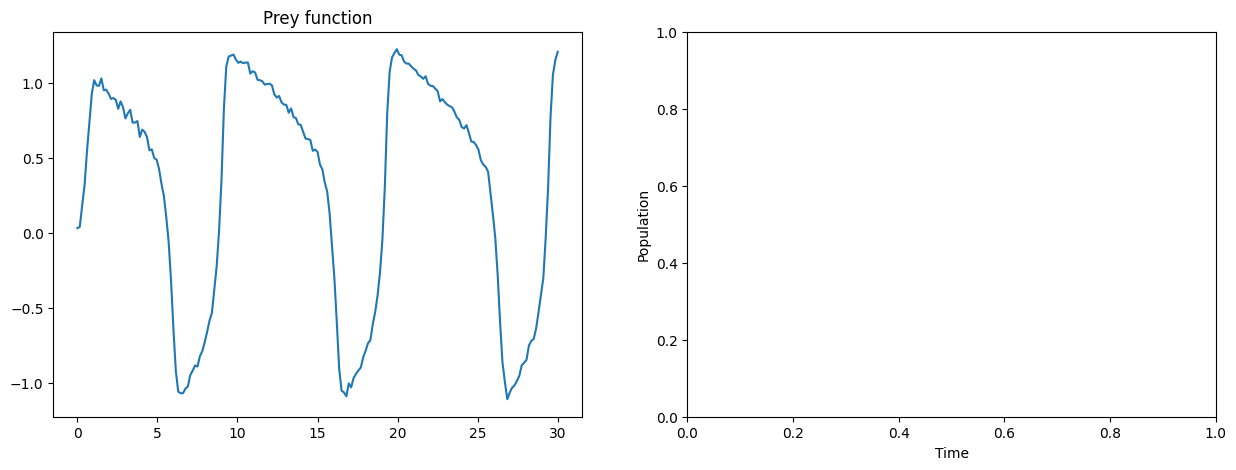

In [50]:
print(alpha,beta,gamma)
a=0
nk=15
fig,ax = plt.subplots(1, 2,figsize=(15,5))
fig.set_label("hello")
plt.xlabel("Time")
plt.ylabel("Population")

ax[0].title.set_text("Prey function")
ax[0].plot(t,y1, label="Input")

predictions = LSFE1(t, X0, nk, [a,b], FHNSolutions)[0] # y~(t) in Poyton 2006
X01.append(predictions)
# print(predictions)
ax[0].plot(t,predictions, label="LSFE")
# print(statis(y1-noise1,predictions,noise1))

es1 = PsLS(t,y1,FHNFit1,2)
print("PsLS 1",es1)
predictions1 = FHNSolver1(t,es1[0], es1[1], es1[2], X0)
ax[0].plot(t,predictions1, label="PsLS")
print(statis(y1-noise1,predictions1,noise1))


nk=10
ax[1].plot(t,y2, label="Input")
ax[1].title.set_text("Predator function")
predictions = LSFE2(t, X0, nk, [a,b], FHNSolutions)[0]
X01.append(predictions)
ax[1].plot(t,predictions, label="LSFE")
# print(statis(y2-noise2,predictions,noise2))

es = PsLS(t,y2,FHNFit2,2)
print("PsLS 2",es)
predictions = FHNSolver2(t,es[0], es[1], es[2], X0)
ax[1].plot(t,predictions, label="PsLS")
print(statis(y2-noise2,predictions,noise2))

ax[0].legend()
ax[1].legend()
plt.show()



nk=15
dt = t[1]-t[0]
y1P = np.gradient(y1,dt)
y2P = np.gradient(y2,dt)

fig,ax = plt.subplots(1, 2,figsize=(15,5))
fig.set_label("hello")
plt.xlabel("Time")
plt.ylabel("Population")

ax[0].title.set_text("Prey function")
ax[0].plot(t,y1P, label="Input")


es = PsLS(t,y1P,FHNDerivative1,2)
print("PsLS 1",es)
predictions = FHNDerivative1(t,es[0], es[1], es[2])
ax[0].plot(t,predictions, label="PsLS")
print(statis(y1P-noise1,predictions,noise1))


nk=10
ax[1].plot(t,y2P, label="Input")
ax[1].title.set_text("Predator function")


es = PsLS(t,y2P,FHNDerivative2,2)
print("PsLS 2",es)
predictions = FHNDerivative2(t,es[0], es[1], es[2])
ax[1].plot(t,predictions, label="PsLS")
print(statis(y2P-noise2,predictions,noise2))

ax[0].legend()
ax[1].legend()
plt.show()

0.34 0.2 3.0
PsLS 1 [0.37819496 0.46213414 2.29184632]


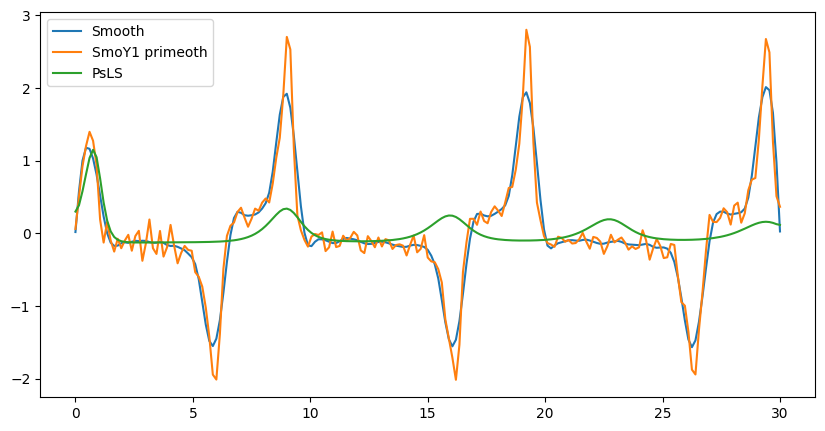

PsLS 2 [0.33019587 0.24596169 3.00352086]


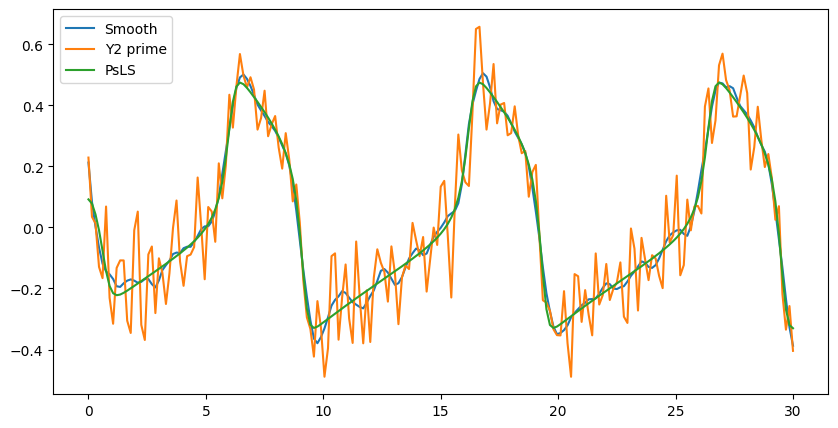

In [47]:
def FHNDerivative1(t,alpha,beta,gamma): 
#     dt = t[1]-t[0]
    return np.gradient(FHNFit1(t,alpha,beta,gamma),dt)

def FHNDerivative2(t,alpha,beta,gamma): 
#     dt = t[1]-t[0]
    return np.gradient(FHNFit2(t,alpha,beta,gamma),dt)

   
# print(integrate.odeint(FHNDFit,X0,y))
print(alpha,beta,gamma)
dt = t[1]-t[0]
y1P = np.gradient(y1,dt)
y2P = np.gradient(y2,dt)

# plt.plot(t,FHNDerivative1(t,alpha,beta,gamma))

smoothY = localreg(t, y1P, degree = 2, kernel = rbf.epanechnikov)
plt.figure(figsize=(10,5))
plt.plot(t,smoothY, label ="Smooth")
es = sp.optimize.curve_fit(FHNDerivative1, t, y1P, full_output = 1)[0]
print("PsLS 1",es)
predictions = FHNDerivative1(t,es[0], es[1], es[2])
plt.plot(t,y1P, label ="SmoY1 primeoth")
plt.plot(t,predictions, label ="PsLS")
plt.legend()
plt.show()


smoothY = localreg(t, y2P, degree = 2, kernel = rbf.epanechnikov)
plt.figure(figsize=(10,5))
plt.plot(t,smoothY, label ="Smooth")
es = sp.optimize.curve_fit(FHNDerivative2, t, smoothY, full_output = 1)[0]
print("PsLS 2",es)
predictions = FHNDerivative2(t,es[0], es[1], es[2])
plt.plot(t,y2P,label ="Y2 prime")
plt.plot(t,predictions,label ="PsLS")
plt.legend()
plt.show()

In [52]:
def SquaredError2(InitialParameterGuess, WhiteSignal):
    
    try:
       
        cSolution=LVSolver2(t,paramEst[0], paramEst[1], paramEst[2], paramEst[3], X0)
    
        error=[(val-sal)**2 for val,sal in zip(cSolution,WhiteSignal)]
        
    except RuntimeError:
        
        error=[10,10]
    
    return sum(error)

def SquaredError1(InitialParameterGuess, WhiteSignal):
    
    try:

        cSolution=LVSolver1(t,paramEst[0], paramEst[1], paramEst[2], paramEst[3], X0)
    
        error=[(val-sal)**2 for val,sal in zip(cSolution,WhiteSignal)]
        
    except RuntimeError:
        
        error=[10,10]
    
    return sum(error)

### Lotka-Volterra equations for predator-prey system

In [54]:
def LotkaVolterra(alpha, beta, delta, gamma, X):
    x1 = X[0]
    x2 = X[1]
    dotx1 = x1 * (alpha - beta * x2)
    dotx2 = x2 * (-delta + gamma * x1)
    return np.array([dotx1, dotx2])


def LVSolution(X0,t):

    return LotkaVolterra(alpha,beta,gamma,delta,X0)


def LVSolver1(t,alpha,beta,gamma,delta,X0):
    
    cAlpha=alpha
    cBeta=beta
    cGamma=gamma
    cDelta=delta
    
    cInit=X0
    
    def LocalModel(cInit,t):
        
        return LotkaVolterra(cAlpha,cBeta,cGamma,cDelta,cInit)
    
    Solution=odeint(LocalModel,cInit,t)
    
    return Solution[:,0]

def LVFit1(t,alpha,beta,gamma,delta):
    
    return LVSolver1(t,alpha,beta,gamma,delta,X0)

def LVDFit1(t,alpha,beta,gamma,delta):
     return np.gradient(LVSolver1(t,alpha,beta,gamma,delta,X0),dt)


def LVSolver2(t,alpha,beta,gamma,delta,X0):
    
    cAlpha=alpha
    cBeta=beta
    cGamma=gamma
    cDelta=delta
    
    cInit=X0
    
    def LocalModel(cInit,t):
        
        return LotkaVolterra(cAlpha,cBeta,cGamma,cDelta,cInit)
    
    Solution=odeint(LocalModel,cInit,t)
    
    return Solution[:,1]

def LVFit2(t,alpha,beta,gamma,delta):
    
    return LVSolver2(t,alpha,beta,gamma,delta,X0)

def LVDFit2(t,alpha,beta,gamma,delta):
     return np.gradient(LVSolver2(t,alpha,beta,gamma,delta,X0),dt)


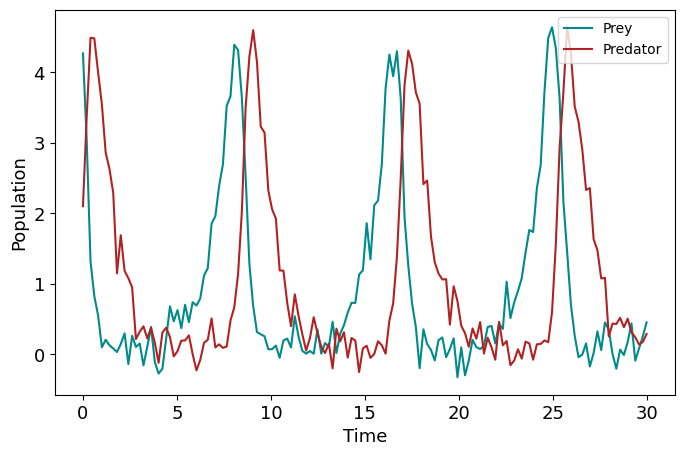

In [74]:
Nt = 150
a = 0
b = 30
t=np.linspace(0,b,Nt)

#Parameters of the model 

# # deer and wolves
alpha=1.
beta=1.
gamma=1.
delta=1.
x10 = 4
x20 = 2


# #baboons and cheetahs
# #b=25
# alpha=2/3
# beta=4/3
# gamma=1.
# delta=1.
# x10 = 0.9
# x20 = 1.8
# nk1 = 30
# nk2 = 40


# rabbits and wolves
# # b=30
# alpha=0.25
# beta=0.55
# gamma=0.3
# delta=0.6
# x10 = 3
# x20 = 1

X0 = [x10, x20]

solutions = odeint(LVSolution, X0, t)
y1 = solutions[:,0]
y2 = solutions[:,1]
# plt.plot(t,y1, label = "Pray")
# plt.plot(t,y2, label = "Predator")
# plt.legend()
np.random.seed(10)
fig=plt.figure(figsize=(8,5))
plt.xlabel("Time",fontsize=13)
plt.ylabel("Population",fontsize=13)

noise1 = np.random.normal(0,0.2, Nt)

y1 = y1 + noise1
noise2 = np.random.normal(0,0.2, Nt)
y2 = y2 + noise2

plt.plot(t,y1, label="Prey", color="darkcyan")
plt.plot(t,y2, label="Predator", color="firebrick")


plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
fig.savefig("R&W.png")
plt.legend()
dt = t[1] - t[0]
y1P = LVDFit1(t,alpha,beta,gamma,delta) + noise1
y2P = LVDFit2(t,alpha,beta,gamma,delta) + noise2


0 30
1.0 1.0 1.0 1.0
LSFE 1 50
(KstestResult(statistic=0.06, pvalue=0.9511113939522167), 0.13160011575212216, 0.9892109935623841)
Time LSFE: 0.5384879112243652


 /Users/bianca/opt/anaconda3/lib/python3.8/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning:Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.


Time PsLS: 0.6982669830322266
PsLS 1 [1.229234   0.69831848 0.63281974 0.55501356]
(KstestResult(statistic=0.28, pvalue=1.388333892239179e-05), 0.3385296789474037, 0.9286058859973981)


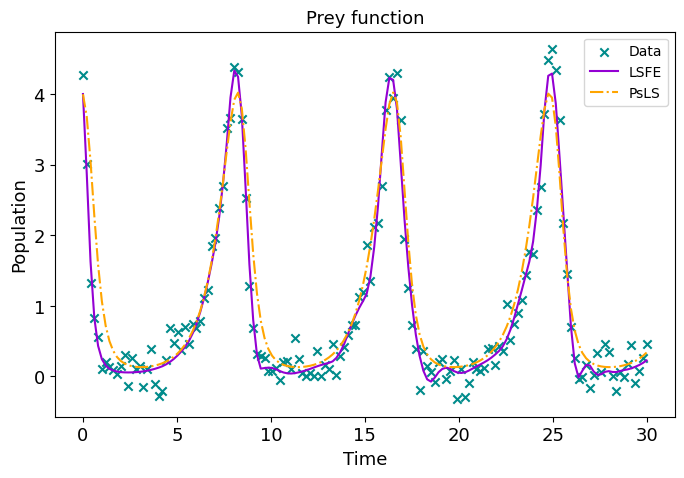

LSFE 2 50
(KstestResult(statistic=0.06, pvalue=0.9511113939522167), 0.09873839125134141, 0.9945706855126829)
Time LSFE: 0.5677351951599121
Time PsLS: 0.6166012287139893
PsLS 2 [0.2369511  0.22764848 2.72888267 0.92674316]
(KstestResult(statistic=0.24, pvalue=0.00033473405864338295), 0.4815693401061318, 0.8708511442696968)


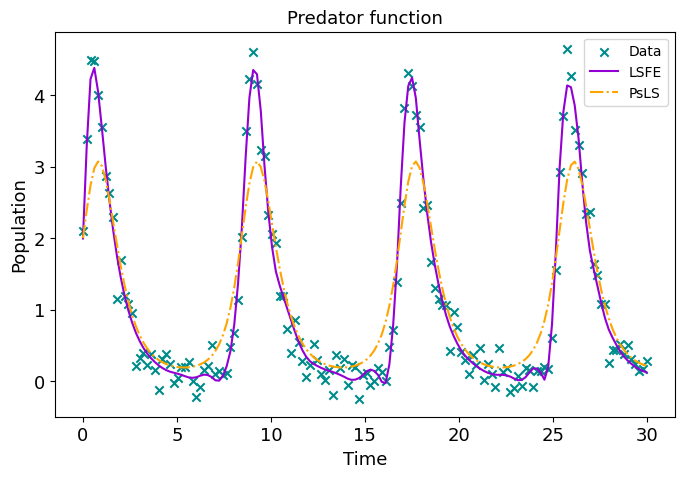

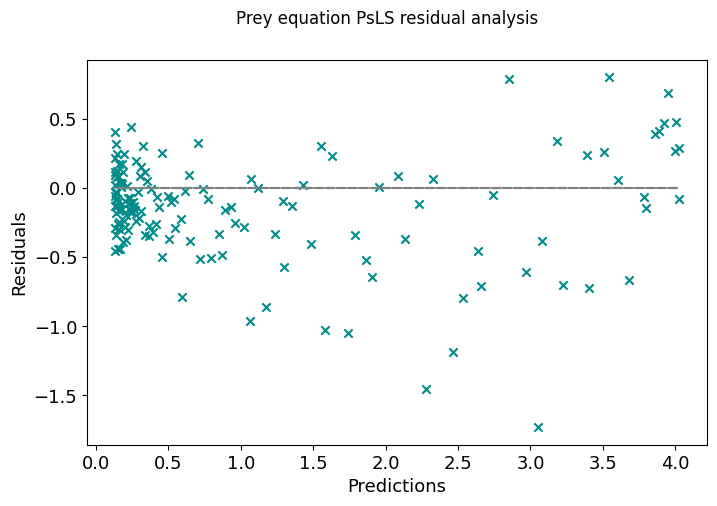

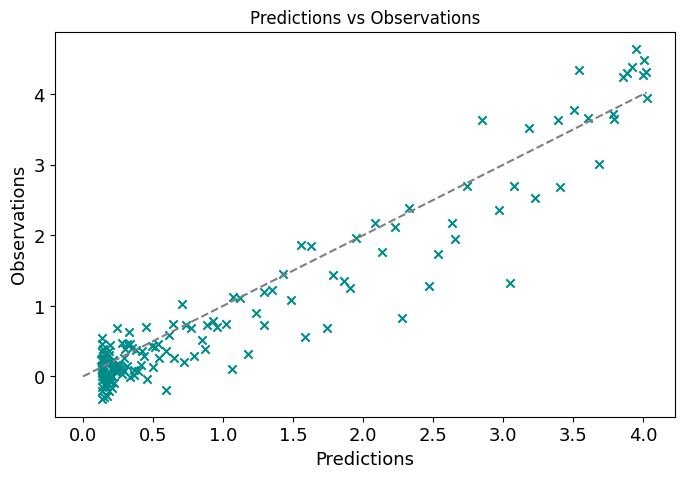

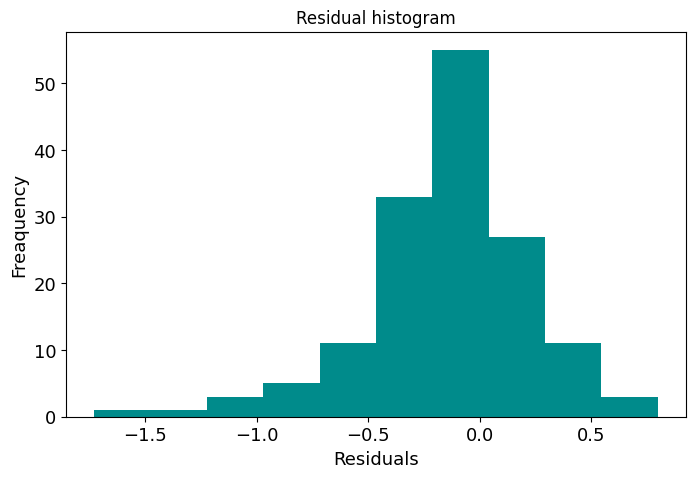

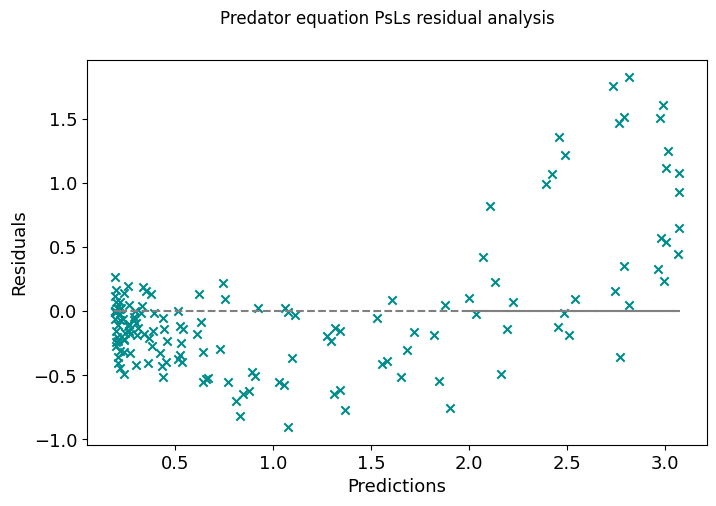

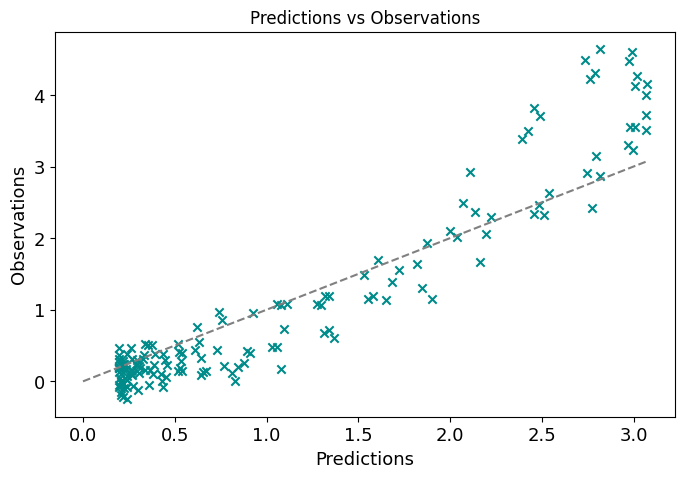

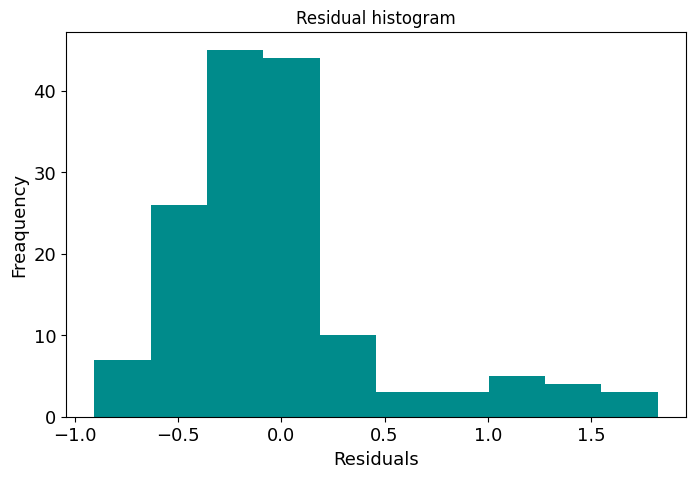

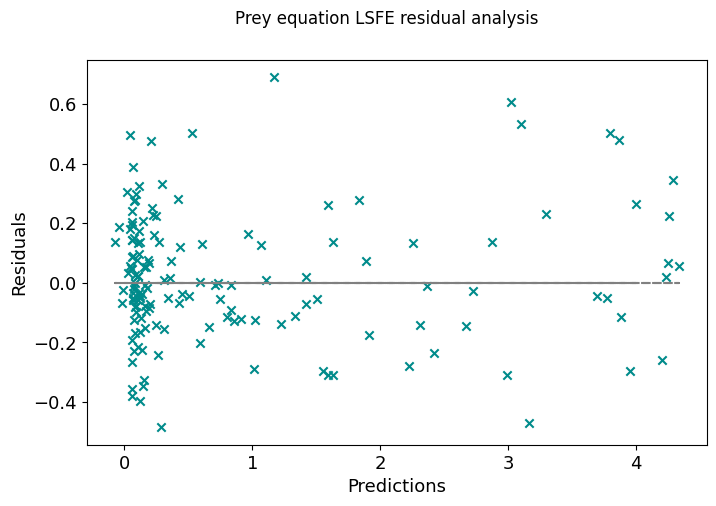

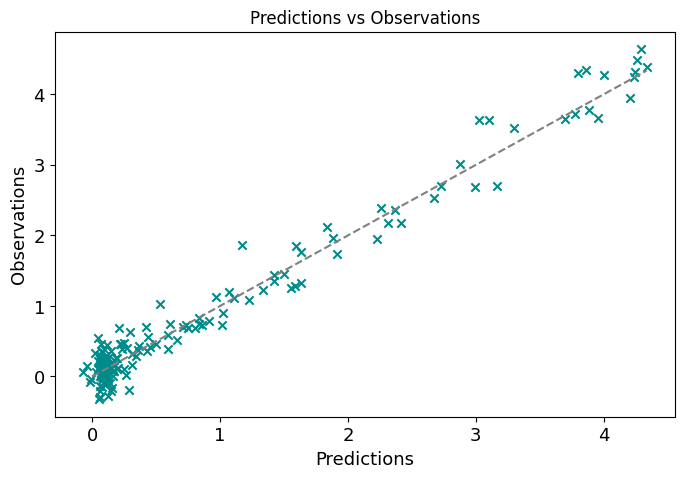

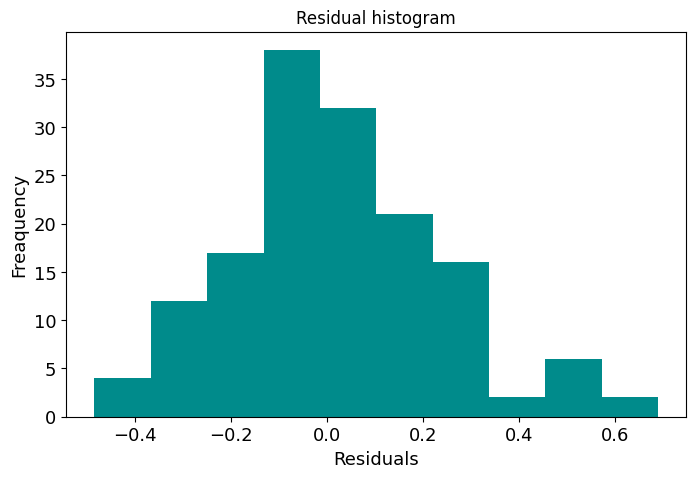

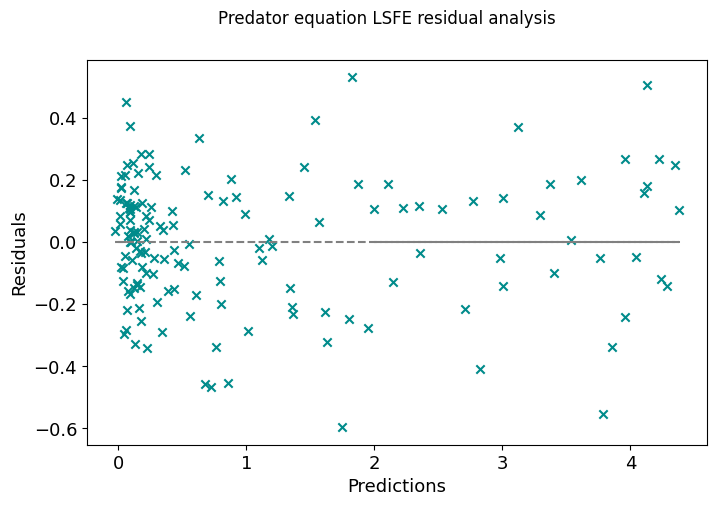

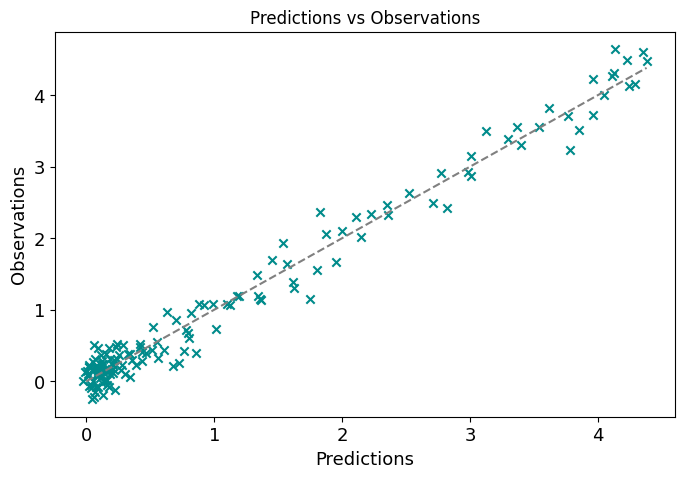

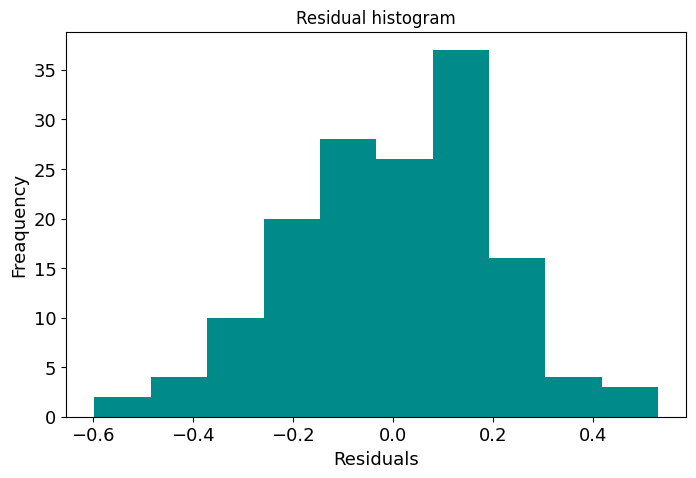

In [75]:
# nk=10
X01 = []
print(a,b)

# Lotka voltera model plots
print(alpha, beta, gamma, delta)
nk=10
# fig,ax = plt.subplots(1, 2,figsize=(18,5))
fig=plt.figure(figsize=(8,5))
plt.xlabel("Time",fontsize=13)
plt.ylabel("Population",fontsize=13)
plt.title("Prey function",fontsize=13)
plt.scatter(t,y1, label="Data",color="darkcyan", marker = 'x')


predictions, f1 = LSFE1(t, X0, nk, [a,b], LVSolution) # y~(t) in Poyton 2006
X01.append(predictions)
plt.plot(t,predictions, label="LSFE", color = "darkviolet")


es = PsLS(t,y1,LVFit1,1,rbf.epanechnikov)
print("PsLS 1",es)
predictions1 = LVSolver1(t,es[0], es[1], es[2], es[3], X0)
plt.plot(t,predictions1, label="PsLS", color = "orange", ls="-.")
print(statis(y1-noise1,predictions1,noise1))
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
fig.savefig("PreyPredicitons.png")
plt.legend()
plt.show()

fig=plt.figure(figsize=(8,5))
nk=10
plt.scatter(t,y2, label="Data", color="darkcyan", marker = 'x')
plt.title("Predator function",fontsize=13)
plt.xlabel("Time",fontsize=13)
plt.ylabel("Population",fontsize=13)

predictions, f2 = LSFE2(t, X0, nk, [a,b], LVSolution)
X01.append(predictions)
plt.plot(t,predictions, label="LSFE", color = "darkviolet")


es = PsLS(t,y2,LVFit2,1,rbf.epanechnikov)
print("PsLS 2",es)
predictions2 = LVSolver2(t,es[0], es[1], es[2], es[3], X0)
plt.plot(t,predictions2, label="PsLS", color = "orange", ls="-.")
print(statis(y2-noise2,predictions2,noise2))
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
fig.savefig("PredatorPredicitons.png")
plt.legend()
plt.show()


residualAnalysis(t, y1, predictions1, noise1, "Prey equation PsLS residual analysis")
residualAnalysis(t, y2, predictions2, noise2, "Predator equation PsLs residual analysis")
residualAnalysis(t, y1, X01[0], noise1, "Prey equation LSFE residual analysis")
residualAnalysis(t, y2, X01[1], noise2, "Predator equation LSFE residual analysis")

# Sensitivity analysis

## Sample size

In [76]:
n = 30
K = 10**4  # carrying capacity of E.coli Colony Forming Units(CFU)/g for feed codition
r = 0.75 # groth rate E.coli per day for feed casw
x0 = 10
b = 30
nk = 10
errors3 = []
errors4 = []
size = []


for i in range(30):

    trainingT = np.linspace(0,b,n)
    trainingY = logisticEquation(trainingT,r,K).flatten() # ODE solutions

    noiseTraining = np.random.normal(0,0.2,n)
    # print(t, trainingY)
    noisyY = trainingY + noiseTraining
    noisyY[:50] = np.abs(noisyY[:50]) + 5

    # # noise
#     nk = 15
    estimations = LSFELG(trainingT, nk, [0,b], noisyY, noiseTraining)
    e1,e2 = sp.optimize.curve_fit(logisticEquation, trainingT , estimations, full_output = 1)[0]
    predictions1 = predict(trainingT,e1,e2)
    errors3.append(statis(trainingY,predictions1,noiseTraining)[1])
    
    e1,e2 = PsLS(trainingT, noisyY, logisticEquation, 1, rbf.epanechnikov, [e1,e2])
    predictions = predict(trainingT,e1,e2)
    errors4.append(statis(trainingY,predictions,noiseTraining)[1])
    
    size.append(n)
    n += 10
 

11 
 (KstestResult(statistic=0.7666666666666667, pvalue=6.531235554884833e-09), 31.54798582981865, 0.9999460729218653)
Time PsLS: 0.059944868087768555
11 
 (KstestResult(statistic=0.75, pvalue=3.063035734104128e-11), 30.949193025944172, 0.999946875406431)
Time PsLS: 0.07062506675720215
11 
 (KstestResult(statistic=0.74, pvalue=1.409544601041165e-13), 30.71578572060579, 0.9999469425959907)
Time PsLS: 0.2076430320739746
11 
 (KstestResult(statistic=0.6, pvalue=2.250626219936777e-10), 30.58361420825043, 0.9999468946359806)
Time PsLS: 0.07364177703857422
11 
 (KstestResult(statistic=0.6428571428571429, pvalue=6.32491373657966e-14), 30.3858944350987, 0.9999472233298465)
Time PsLS: 0.07474708557128906
11 
 (KstestResult(statistic=0.6, pvalue=1.0096098989064368e-13), 30.414797644722352, 0.9999468557862696)
Time PsLS: 0.07161378860473633
11 
 (KstestResult(statistic=0.5888888888888889, pvalue=8.321683981436618e-15), 30.12107841985742, 0.9999476706193479)
Time PsLS: 0.061234235763549805
11 
 (K

[6.98696333 7.36584664 7.48099919 7.52469808 7.54341823 7.5518464
 7.55559198 7.55705865 7.55736437 7.55707544 7.556469   7.55571569
 7.55489742 7.55407251 7.55325358 7.55246769 7.55173322 7.55100403
 7.55035589 7.54972337 7.54913652 7.54858148 7.54805577 7.54756034
 7.54711237 7.54667309 7.54625533 7.54588203 7.54551352 7.54516825]


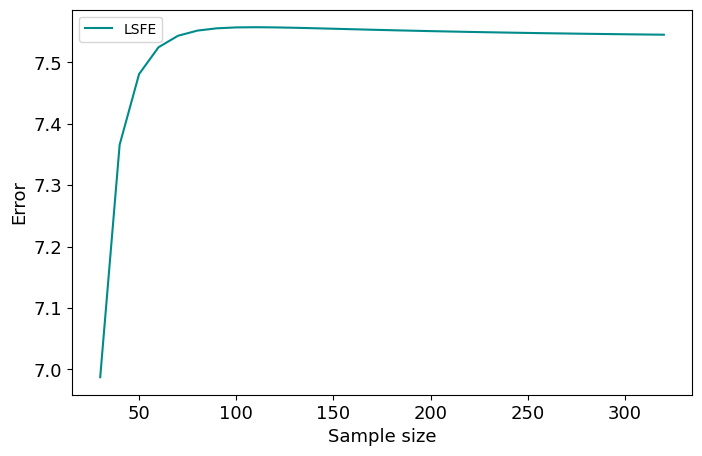

[ 4.56305426 10.7180448   7.48981657  5.33710846  9.57340824  9.43932502
  8.44619414 10.30348601 10.37925766  9.77896098 10.77257845 10.89544516
 10.48902035 11.14212344 11.23917021 10.91345495 11.35976905 11.37074321
 11.12570111 11.42666028 11.42613656 11.22679905 11.44919068 11.46512502
 11.30902506 11.45274495 11.46602427 11.31603767 11.44393524 11.46891977]


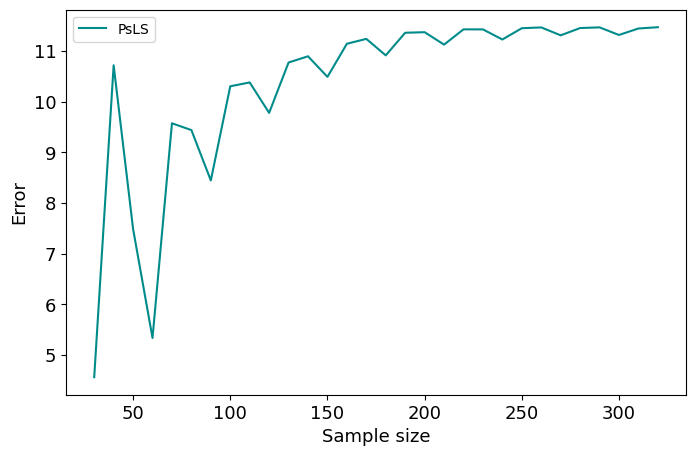

In [77]:
fig=plt.figure(figsize=(8,5))
# plt.subplot(1,2,2)
plt.xlabel("Sample size",fontsize=13)
plt.ylabel("Error",fontsize=13) 
errors3 = np.array(errors3)
size = np.array(size)
plt.plot(size , errors3, color = "darkcyan", label="LSFE")
print(errors3)
plt.legend()
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
fig.savefig('LS1.png')
plt.show()


fig=plt.figure(figsize=(8,5))
# plt.subplot(1,2,2)
plt.xlabel("Sample size",fontsize=13)
plt.ylabel("Error",fontsize=13) 
errors4 = np.array(errors4)
plt.plot(size , errors4 , color = "darkcyan", label="PsLS")
print(errors4)
plt.legend()
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
fig.savefig('PS1.png')
plt.show()


In [78]:
Nt = 30
a = 0
b = 30

errors1 = []
errors2 = []
errors3 = []
errors4 = []
size = []
sigma = 0.2
nk = 10
np.random.seed(15)

for i in range(30): 
    

    t=np.linspace(0,b,Nt)
    solutions = odeint(LVSolution, X0, t)
    y1 = solutions[:,0]
    y2 = solutions[:,1]
    noise1 = np.random.normal(0,0.2, Nt)
    y1 = y1 + noise1
    noise2 = np.random.normal(0,0.2, Nt)
    y2 = y2 + noise2
    
    predictions, f1 = LSFE1(t, X0, nk, [a,b], LVSolution)
#     plt.plot(t, predictions, label=Nt)
    errors3.append(statis(y1-noise1,predictions,noise1)[1])
    
    es = PsLS(t,y1,LVFit1,1, rbf.biweight)
    predictions1 = LVSolver1(t,es[0], es[1], es[2], es[3], X0)
#     plt.plot(t, predictions1, label=Nt)
    errors1.append(statis(y1-noise1,predictions1,noise1)[1])
    
    predictions, f2 = LSFE2(t, X0, nk, [a,b], LVSolution)
#     plt.plot(t, predictions, label=Nt)
    errors4.append(statis(y2-noise2,predictions,noise2)[1])
    
    es = PsLS(t,y2,LVFit2,1, rbf.biweight)
    predictions1 = LVSolver2(t,es[0], es[1], es[2], es[3], X0)
    errors2.append(statis(y2-noise1,predictions1,noise2)[1])
    
    size.append(Nt)
    Nt +=10


LSFE 1 50
(KstestResult(statistic=0.1, pvalue=0.9988393756362763), 0.11876242363080688, 0.9932397452624027)
Time LSFE: 0.493178129196167
Time PsLS: 0.13888907432556152
LSFE 2 50
(KstestResult(statistic=0.13333333333333333, pvalue=0.9578462903438838), 0.10326372607431157, 0.9940565046362189)
Time LSFE: 0.3542671203613281
Time PsLS: 0.13140296936035156
LSFE 1 50
(KstestResult(statistic=0.125, pvalue=0.9188052214121167), 0.16424208886802139, 0.9849349302636285)
Time LSFE: 0.35703110694885254
Time PsLS: 0.44510579109191895
LSFE 2 50
(KstestResult(statistic=0.15, pvalue=0.7659314523482239), 0.09789177254563597, 0.9943513851467426)
Time LSFE: 0.337522029876709
Time PsLS: 0.21443390846252441
LSFE 1 50
(KstestResult(statistic=0.08, pvalue=0.9977109764909107), 0.11711214926982844, 0.9920324403716911)
Time LSFE: 0.34984898567199707
Time PsLS: 2.0486230850219727
LSFE 2 50
(KstestResult(statistic=0.08, pvalue=0.9977109764909107), 0.09691765985617333, 0.9948569933882172)
Time LSFE: 0.50295305252075

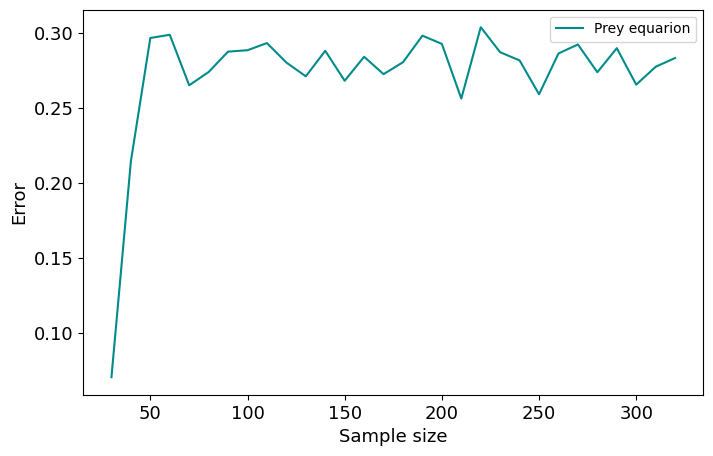

[0.07048448 0.21454617 0.29667843 0.29880673 0.26513387 0.27400217
 0.28756642 0.28850589 0.29329037 0.28029712 0.2711104  0.28811535
 0.26814636 0.28415332 0.27256413 0.28050838 0.2982134  0.29272732
 0.25626323 0.30384728 0.28716665 0.28172175 0.25912917 0.28636035
 0.29234333 0.27384587 0.28987055 0.26556278 0.27747366 0.28332648]
[0.26648401 0.46517463 0.47920944 0.48734674 0.50346125 0.49430423
 0.50941899 0.52781908 0.50880884 0.50188276 0.50278126 0.50019099
 0.49666825 0.49296774 0.52925178 0.48878757 0.48989147 0.48457206
 0.48666174 0.49580601 0.48418661 0.48003122 0.50944849 0.47116928
 0.48285281 0.51887314 0.48078621 0.5184636  0.50216185 0.50881078]


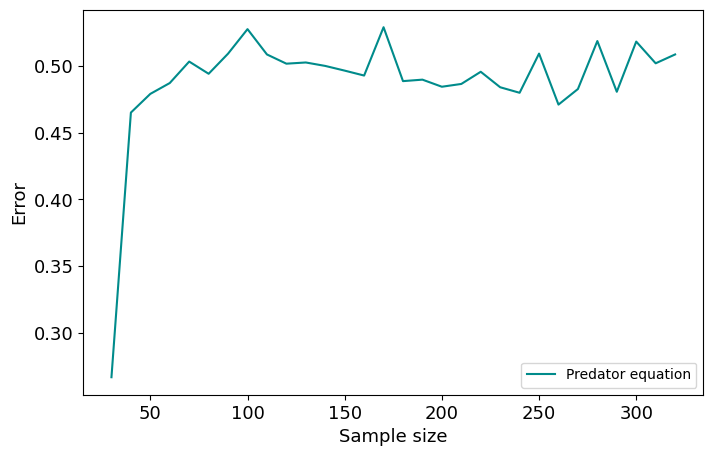

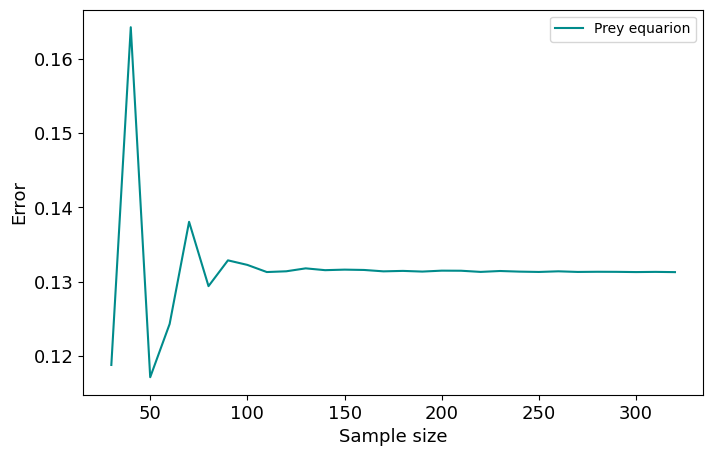

[0.11876242 0.16424209 0.11711215 0.12428397 0.13803852 0.12937603
 0.13284999 0.1322359  0.13127525 0.1313762  0.13177176 0.1315277
 0.13160012 0.13155573 0.13136878 0.13142901 0.13133807 0.13146239
 0.13145015 0.13129503 0.13141531 0.13133177 0.13128821 0.1313733
 0.13129003 0.13131266 0.13130284 0.13127103 0.13129732 0.13126344]
[0.10326373 0.09789177 0.09691766 0.09796375 0.10115439 0.09463322
 0.1011782  0.09812913 0.09890756 0.0988229  0.09872001 0.09909487
 0.09873839 0.09872804 0.09851214 0.09852226 0.09857279 0.09865618
 0.09874019 0.09858585 0.09861893 0.09851942 0.09848138 0.09858431
 0.09852072 0.09857196 0.09855402 0.09851531 0.09855899 0.09850536]


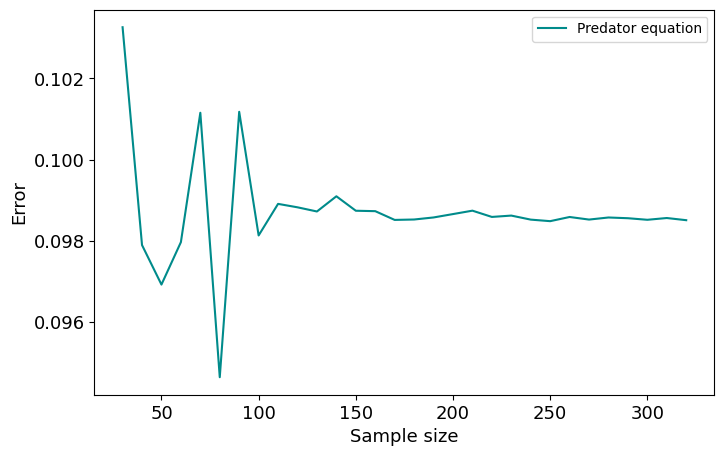

In [80]:

fig=plt.figure(figsize=(8,5))

plt.xlabel("Sample size",fontsize=13)
plt.ylabel("Error",fontsize=13)   
# plt.title("PsLS on prey equation")
errors1 = np.array(errors1)
size = np.array(size)
plt.plot(size , errors1, color = "darkcyan", label="Prey equarion")
plt.legend()
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
fig.savefig('PS11.png')
plt.show()
print(errors1)

fig=plt.figure(figsize=(8,5))
plt.xlabel("Sample size",fontsize=13)
plt.ylabel("Error",fontsize=13) 
# plt.title("PsLS on predator equation")
errors2 = np.array(errors2)
plt.plot(size , errors2, color = "darkcyan", label="Predator equation")
print(errors2)
plt.legend()
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
fig.savefig('PS12.png')
plt.show()


fig=plt.figure(figsize=(8,5))
plt.xlabel("Sample size",fontsize=13)
plt.ylabel("Error",fontsize=13)
# plt.title("LSFE on prey equation")
errors3 = np.array(errors3)
plt.plot(size , errors3, color = "darkcyan", label="Prey equarion")
plt.legend()
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
fig.savefig('LS11.png')
plt.show()
print(errors3)

fig=plt.figure(figsize=(8,5))
plt.xlabel("Sample size",fontsize=13)
plt.ylabel("Error",fontsize=13) 
# plt.title("LSFE on predator equation")
errors4 = np.array(errors4)
plt.plot(size , errors4, color = "darkcyan", label="Predator equation")
print(errors4)
plt.legend()
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
fig.savefig('LS12.png')
plt.show()

## Noise sensitivity

In [81]:
# Logistic growth
n = 150 #no of smaples
K = 10**4  # carrying capacity of E.coli Colony Forming Units(CFU)/g for feed codition
r = 0.75 # groth rate E.coli per day for feed casw
x0 = 10
errors1 = []
errors2 = []
errors3 = []
errors4 = []
sigma = 0.2
sd = []
size = []
nk = 10
np.random.seed(15)

for i in range(30):

    trainingT = np.linspace(0,30,n)
    trainingY = logisticEquation(trainingT,r,K).flatten() # ODE solutions

    noiseTraining = np.random.normal(0,sigma,n)
    # print(t, trainingY)
    noisyY = trainingY + noiseTraining
    noisyY[:50] = np.abs(noisyY[:50]) + 5

    # # noise
    nk = 15
    estimations = LSFELG(trainingT, nk, [0,30], noisyY, noiseTraining)
    e1,e2 = sp.optimize.curve_fit(logisticEquation, trainingT , estimations, full_output = 1)[0]
    predictions1 = predict(trainingT,e1,e2)
    errors1.append(statis(trainingY,predictions1,noiseTraining)[1])
    
    e1,e2 = PsLS(trainingT, noisyY, logisticEquation, 1, rbf.epanechnikov, [e1,e2])
    predictions = predict(trainingT,e1,e2)
    errors2.append(statis(trainingY,predictions,noiseTraining)[1])
    
    sd.append(sigma)
    sigma += 0.2


15 
 (KstestResult(statistic=0.6533333333333333, pvalue=1.5585523187859256e-30), 19.042917477348094, 0.9999788232106017)


Time PsLS: 0.14897823333740234
15 
 (KstestResult(statistic=0.5933333333333334, pvalue=7.58847782159937e-25), 19.01536324088519, 0.9999788846456235)
Time PsLS: 0.08162999153137207
15 
 (KstestResult(statistic=0.5, pvalue=2.0895602771964966e-17), 19.043636553295315, 0.9999788215554886)
Time PsLS: 0.07280206680297852
15 
 (KstestResult(statistic=0.5266666666666666, pvalue=2.2756141085163098e-19), 19.131137626660017, 0.9999786259385833)
Time PsLS: 0.10737729072570801
15 
 (KstestResult(statistic=0.4866666666666667, pvalue=1.799621291365404e-16), 19.129166002256543, 0.9999786305857463)
Time PsLS: 0.08913493156433105
15 
 (KstestResult(statistic=0.4866666666666667, pvalue=1.799621291365404e-16), 19.09672818282083, 0.9999787019451327)
Time PsLS: 0.13470101356506348
15 
 (KstestResult(statistic=0.5066666666666667, pvalue=6.934381450873329e-18), 18.94580474732723, 0.9999790390423692)
Time PsLS: 0.1865520477294922
15 
 (KstestResult(statistic=0.36666666666666664, pvalue=2.324883884553262e-09), 

[4.71572671 4.71572671 4.71572671 4.71572671 4.71572671 4.71572671
 4.71572671 4.71572671 4.71572671 4.71572671 4.71572671 4.71572671
 4.71572671 4.71572671 4.71572671 4.71572671 4.71572671 4.71572671
 4.71572671 4.71572671 4.71572671 4.71572671 4.71572671 4.71572671
 4.71572671 4.71572671 4.71572671 4.71572671 4.71572671 4.71572671]


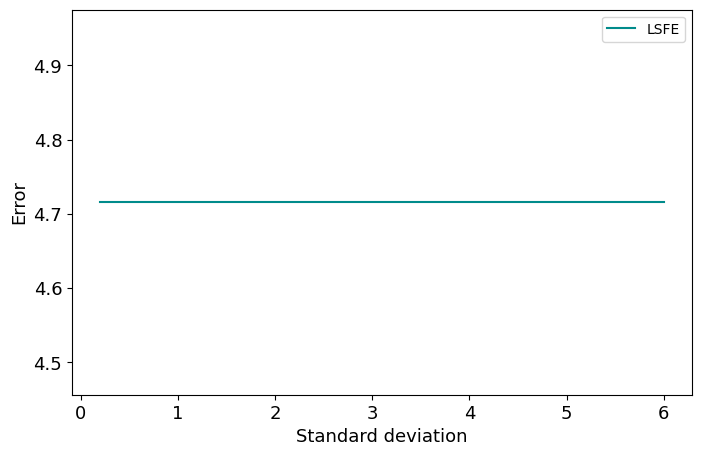

[10.48667876 10.4915062  10.5182585  10.51087259 10.56857079 10.6012918
 10.33844523 10.41887917 10.54862508 10.75536122 10.81911821 10.73322683
 10.54128412 10.38668891 10.63479401 10.51048635  9.93789428 10.71863511
 10.08214988 10.52255566 10.91604505 10.53253035 10.76215761 10.36517522
 10.35367427 11.11459225 10.98000834 10.61719597 11.01104935 10.56976887]


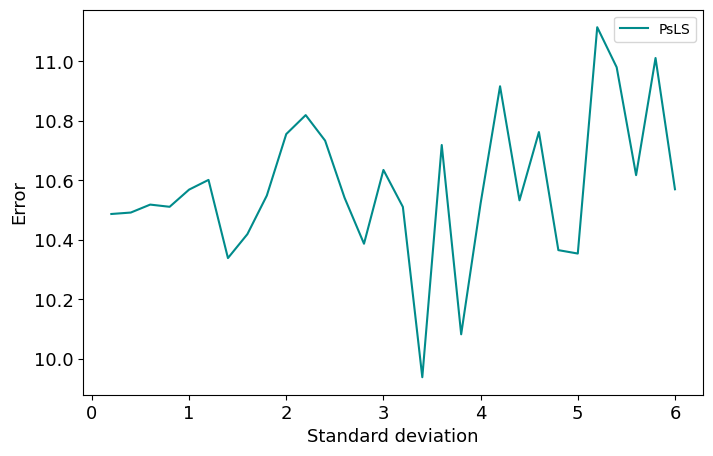

In [82]:
fig=plt.figure(figsize=(8,5))
plt.xlabel("Standard deviation",fontsize=13)
plt.ylabel("Error",fontsize=13) 
errors1 = np.array(errors1)
sd = np.array(sd)
plt.plot(sd , errors1, color = "darkcyan", label="LSFE")
print(errors1)
plt.legend()
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
fig.savefig('LN1.png')
plt.show()

fig=plt.figure(figsize=(8,5))
plt.xlabel("Standard deviation",fontsize=13)
plt.ylabel("Error",fontsize=13) 
errors2 = np.array(errors2)
plt.plot(sd , errors2, color = "darkcyan", label="PsLS")
print(errors2)
plt.legend()
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
fig.savefig('PN1.png')

In [83]:
Nt = 150
a = 0
b = 30

sigma = 0.2
nk = 10
errors1 = []
errors2 = []
errors3 = []
errors4 = []
sd = []
np.random.seed(15)

for i in range(30): 
    print(i)

    t=np.linspace(0,b,Nt)
    solutions = odeint(LVSolution, X0, t)
    y1 = solutions[:,0]
    y2 = solutions[:,1]
    noise1 = np.random.normal(0,sigma, Nt)
    y1 = y1 + noise1
    noise2 = np.random.normal(0,sigma, Nt)
    y2 = y2 + noise2
    
    predictions, f1 = LSFE1(t, X0, nk, [a,b], LVSolution)
    errors3.append(statis(y1-noise1,predictions,noise1)[1])
    
    es = PsLS(t,y1,LVFit1,1, rbf.biweight)
    predictions1 = LVSolver1(t,es[0], es[1], es[2], es[3], X0)
#     plt.plot(t, predictions1, label=sigma)
    errors1.append(statis(y1-noise1,predictions1,noise1)[1])
    
    predictions, f2 = LSFE2(t, X0, nk, [a,b], LVSolution)
#     plt.plot(t, predictions, label=sigma)
    errors4.append(statis(y2-noise2,predictions,noise2)[1])
    
    es = PsLS(t,y2,LVFit2,1, rbf.biweight)
    predictions1 = LVSolver2(t,es[0], es[1], es[2], es[3], X0)
    errors2.append(statis(y2-noise1,predictions1,noise2)[1])
    
    sd.append(sigma)
    sigma += 0.2

# plt.legend()


0


LSFE 1 50
(KstestResult(statistic=0.06, pvalue=0.9511113939522167), 0.13160011575212213, 0.9892109935623841)
Time LSFE: 2.71264910697937
Time PsLS: 3.9829719066619873
LSFE 2 50
(KstestResult(statistic=0.06, pvalue=0.9511113939522167), 0.09873839125134141, 0.9945706855126829)
Time LSFE: 1.2032811641693115
Time PsLS: 1.0539209842681885
1
LSFE 1 50
(KstestResult(statistic=0.04, pvalue=0.9997797100657202), 0.13160011575212213, 0.9892109935623841)
Time LSFE: 0.8477890491485596
Time PsLS: 0.9875271320343018
LSFE 2 50
(KstestResult(statistic=0.04666666666666667, pvalue=0.996947429111569), 0.09873839125134141, 0.9945706855126829)
Time LSFE: 0.4189019203186035
Time PsLS: 0.35012316703796387
2
LSFE 1 50
(KstestResult(statistic=0.03333333333333333, pvalue=0.9999974826701125), 0.13160011575212213, 0.9892109935623841)
Time LSFE: 1.0134148597717285
Time PsLS: 0.7809059619903564
LSFE 2 50
(KstestResult(statistic=0.04666666666666667, pvalue=0.996947429111569), 0.09873839125134141, 0.9945706855126829)


 /Users/bianca/opt/anaconda3/lib/python3.8/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning:Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.


Time PsLS: 0.3796579837799072
LSFE 2 50
(KstestResult(statistic=0.04, pvalue=0.9997797100657202), 0.09873839125134141, 0.9945706855126829)
Time LSFE: 0.4522099494934082
Time PsLS: 0.20856595039367676
4
LSFE 1 50
(KstestResult(statistic=0.03333333333333333, pvalue=0.9999974826701125), 0.13160011575212216, 0.9892109935623841)
Time LSFE: 0.3904991149902344
Time PsLS: 0.5642380714416504
LSFE 2 50
(KstestResult(statistic=0.03333333333333333, pvalue=0.9999974826701125), 0.09873839125134141, 0.9945706855126829)
Time LSFE: 0.36409616470336914
Time PsLS: 0.3154759407043457
5
LSFE 1 50
(KstestResult(statistic=0.03333333333333333, pvalue=0.9999974826701125), 0.13160011575212213, 0.9892109935623841)
Time LSFE: 0.37404894828796387
Time PsLS: 1.0758769512176514
LSFE 2 50
(KstestResult(statistic=0.02666666666666667, pvalue=0.9999999994745201), 0.09873839125134144, 0.9945706855126829)
Time LSFE: 0.34758520126342773
Time PsLS: 0.5275709629058838
6
LSFE 1 50
(KstestResult(statistic=0.03333333333333333, 

 /Users/bianca/opt/anaconda3/lib/python3.8/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning:Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.


LSFE 2 50
(KstestResult(statistic=0.02, pvalue=0.9999999999999908), 0.09873839125134141, 0.9945706855126829)
Time LSFE: 0.35161709785461426


 /Users/bianca/opt/anaconda3/lib/python3.8/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning:Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.


Time PsLS: 0.4243919849395752
11
LSFE 1 50
(KstestResult(statistic=0.02, pvalue=0.9999999999999908), 0.13160011575212216, 0.9892109935623841)
Time LSFE: 0.4951479434967041
Time PsLS: 0.8086462020874023
LSFE 2 50
(KstestResult(statistic=0.02666666666666667, pvalue=0.9999999994745201), 0.09873839125134141, 0.9945706855126829)
Time LSFE: 0.4204740524291992
Time PsLS: 0.399791955947876
12
LSFE 1 50
(KstestResult(statistic=0.02, pvalue=0.9999999999999908), 0.13160011575212216, 0.9892109935623841)
Time LSFE: 0.3796968460083008
Time PsLS: 0.27181100845336914


 /Users/bianca/opt/anaconda3/lib/python3.8/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning:Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.


LSFE 2 50
(KstestResult(statistic=0.02, pvalue=0.9999999999999908), 0.09873839125134141, 0.9945706855126829)
Time LSFE: 0.43762993812561035
Time PsLS: 0.2546248435974121
13
LSFE 1 50
(KstestResult(statistic=0.02666666666666667, pvalue=0.9999999994745201), 0.13160011575212216, 0.9892109935623841)
Time LSFE: 0.35568809509277344
Time PsLS: 0.34964561462402344
LSFE 2 50
(KstestResult(statistic=0.013333333333333334, pvalue=0.9999999999999998), 0.09873839125134141, 0.9945706855126829)
Time LSFE: 0.37738800048828125
Time PsLS: 0.325545072555542
14
LSFE 1 50
(KstestResult(statistic=0.02, pvalue=0.9999999999999908), 0.13160011575212213, 0.9892109935623841)
Time LSFE: 0.34505319595336914
Time PsLS: 0.5464320182800293


 /Users/bianca/opt/anaconda3/lib/python3.8/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning:Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.


LSFE 2 50
(KstestResult(statistic=0.02, pvalue=0.9999999999999908), 0.09873839125134141, 0.9945706855126829)
Time LSFE: 0.34117698669433594
Time PsLS: 0.14925217628479004
15
LSFE 1 50
(KstestResult(statistic=0.02666666666666667, pvalue=0.9999999994745201), 0.1316001157521221, 0.9892109935623841)
Time LSFE: 0.3399081230163574
Time PsLS: 0.14703989028930664
LSFE 2 50
(KstestResult(statistic=0.02666666666666667, pvalue=0.9999999994745201), 0.09873839125134141, 0.9945706855126829)
Time LSFE: 0.3333292007446289
Time PsLS: 0.21901583671569824
16
LSFE 1 50
(KstestResult(statistic=0.02666666666666667, pvalue=0.9999999994745201), 0.13160011575212216, 0.9892109935623841)
Time LSFE: 0.33782005310058594
Time PsLS: 0.4891059398651123
LSFE 2 50
(KstestResult(statistic=0.02, pvalue=0.9999999999999908), 0.09873839125134141, 0.9945706855126829)
Time LSFE: 0.3803567886352539
Time PsLS: 0.24594402313232422
17
LSFE 1 50
(KstestResult(statistic=0.02, pvalue=0.9999999999999908), 0.1316001157521222, 0.989210

 /Users/bianca/opt/anaconda3/lib/python3.8/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning:Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.


LSFE 2 50
(KstestResult(statistic=0.02, pvalue=0.9999999999999908), 0.09873839125134144, 0.9945706855126829)
Time LSFE: 0.34262609481811523
Time PsLS: 0.2231159210205078
23
LSFE 1 50
(KstestResult(statistic=0.02, pvalue=0.9999999999999908), 0.13160011575212216, 0.9892109935623841)
Time LSFE: 0.3604259490966797
Time PsLS: 0.46073412895202637


 /Users/bianca/opt/anaconda3/lib/python3.8/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning:Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.


LSFE 2 50
(KstestResult(statistic=0.02666666666666667, pvalue=0.9999999994745201), 0.09873839125134141, 0.9945706855126829)
Time LSFE: 0.3402731418609619
Time PsLS: 0.22782492637634277


 /Users/bianca/opt/anaconda3/lib/python3.8/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning:Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.


24
LSFE 1 50
(KstestResult(statistic=0.02, pvalue=0.9999999999999908), 0.1316001157521222, 0.9892109935623841)
Time LSFE: 0.37681102752685547
Time PsLS: 0.4308359622955322
LSFE 2 50
(KstestResult(statistic=0.02, pvalue=0.9999999999999908), 0.09873839125134141, 0.9945706855126829)
Time LSFE: 0.4147670269012451
Time PsLS: 0.12454605102539062
25
LSFE 1 50
(KstestResult(statistic=0.02, pvalue=0.9999999999999908), 0.13160011575212213, 0.9892109935623841)
Time LSFE: 0.40058183670043945
Time PsLS: 0.6959090232849121
LSFE 2 50
(KstestResult(statistic=0.02, pvalue=0.9999999999999908), 0.09873839125134141, 0.9945706855126829)
Time LSFE: 0.5402860641479492


 /Users/bianca/opt/anaconda3/lib/python3.8/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning:Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.


Time PsLS: 0.2731361389160156
26
LSFE 1 50
(KstestResult(statistic=0.02666666666666667, pvalue=0.9999999994745201), 0.13160011575212216, 0.9892109935623841)
Time LSFE: 0.3869750499725342
Time PsLS: 0.2760648727416992
LSFE 2 50
(KstestResult(statistic=0.02, pvalue=0.9999999999999908), 0.09873839125134141, 0.9945706855126829)
Time LSFE: 0.3577752113342285
Time PsLS: 0.4824090003967285
27
LSFE 1 50
(KstestResult(statistic=0.02666666666666667, pvalue=0.9999999994745201), 0.13160011575212216, 0.9892109935623841)
Time LSFE: 0.4008498191833496


 /Users/bianca/opt/anaconda3/lib/python3.8/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning:Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.


Time PsLS: 0.563593864440918
LSFE 2 50
(KstestResult(statistic=0.02, pvalue=0.9999999999999908), 0.09873839125134144, 0.9945706855126829)
Time LSFE: 0.3801460266113281
Time PsLS: 0.4065861701965332
28
LSFE 1 50
(KstestResult(statistic=0.02, pvalue=0.9999999999999908), 0.1316001157521222, 0.9892109935623841)
Time LSFE: 0.36553502082824707
Time PsLS: 0.38400912284851074
LSFE 2 50
(KstestResult(statistic=0.02, pvalue=0.9999999999999908), 0.09873839125134141, 0.9945706855126829)
Time LSFE: 0.341418981552124
Time PsLS: 0.6487159729003906
29
LSFE 1 50
(KstestResult(statistic=0.02666666666666667, pvalue=0.9999999994745201), 0.13160011575212213, 0.9892109935623841)
Time LSFE: 0.3482341766357422


 /Users/bianca/opt/anaconda3/lib/python3.8/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning:Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.


Time PsLS: 0.37166476249694824
LSFE 2 50
(KstestResult(statistic=0.02, pvalue=0.9999999999999908), 0.09873839125134147, 0.9945706855126829)
Time LSFE: 0.459989070892334
Time PsLS: 0.23001790046691895


[0.28063295 0.25828131 0.26165574 0.39889683 0.28237248 0.26825886
 0.38842327 0.23227694 0.59453275 0.2936667  0.57281122 0.38385703
 0.55726453 0.39670818 0.85551556 0.88911311 0.45906639 0.98226482
 0.45335471 0.53685127 0.28577073 0.64447036 0.47034602 0.59684141
 0.33038743 0.65863851 0.84440657 1.21228135 0.51614748 0.95623219]


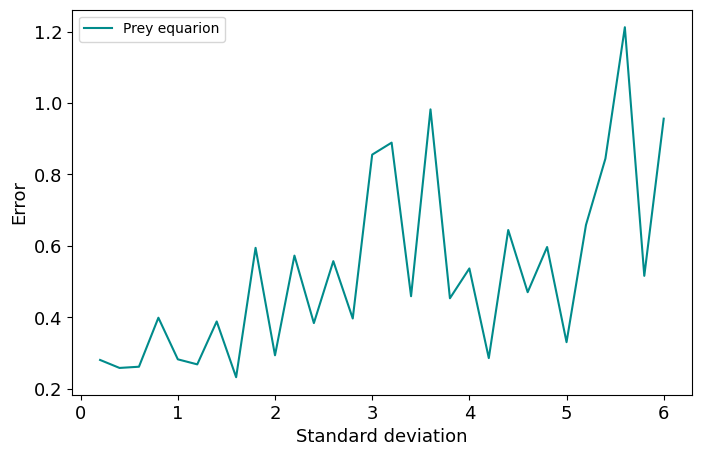

[0.48080341 0.71177608 0.95975257 1.2278771  1.40080781 1.55603981
 2.04934793 2.02350966 2.66475485 2.80373905 3.13053883 3.49118058
 3.39208295 3.75908438 4.14947506 4.51227454 4.68160694 5.15063734
 5.25299607 5.25895362 6.43320096 6.08701073 6.7748209  6.69088407
 7.59208858 7.65459096 6.75126963 7.65671326 8.22190136 8.0463063 ]


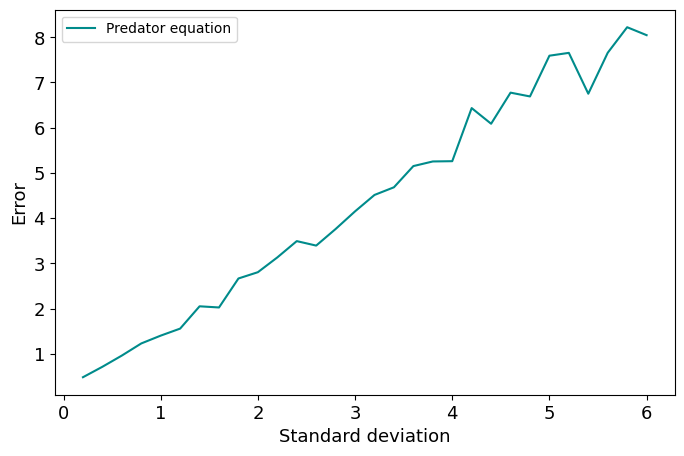

[0.13160012 0.13160012 0.13160012 0.13160012 0.13160012 0.13160012
 0.13160012 0.13160012 0.13160012 0.13160012 0.13160012 0.13160012
 0.13160012 0.13160012 0.13160012 0.13160012 0.13160012 0.13160012
 0.13160012 0.13160012 0.13160012 0.13160012 0.13160012 0.13160012
 0.13160012 0.13160012 0.13160012 0.13160012 0.13160012 0.13160012]


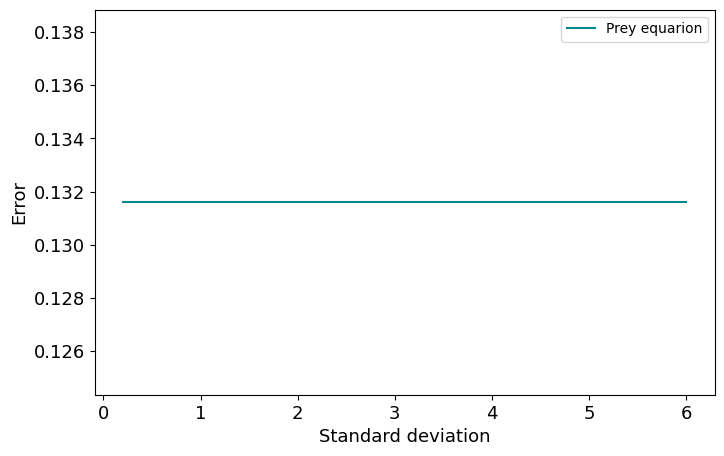

[0.09873839 0.09873839 0.09873839 0.09873839 0.09873839 0.09873839
 0.09873839 0.09873839 0.09873839 0.09873839 0.09873839 0.09873839
 0.09873839 0.09873839 0.09873839 0.09873839 0.09873839 0.09873839
 0.09873839 0.09873839 0.09873839 0.09873839 0.09873839 0.09873839
 0.09873839 0.09873839 0.09873839 0.09873839 0.09873839 0.09873839]


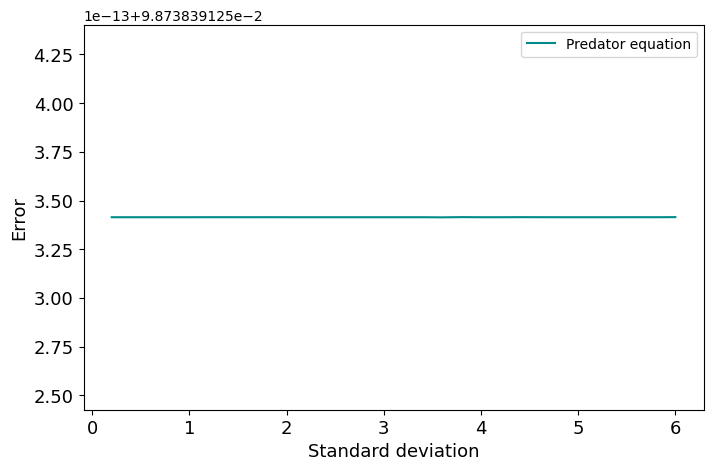

In [84]:
fig=plt.figure(figsize=(8,5))
# plt.subplot(1,2,1)
plt.xlabel("Standard deviation",fontsize=13)
plt.ylabel("Error",fontsize=13)   
errors1 = np.array(errors1)
sd = np.array(sd)
plt.plot(sd , errors1, color = "darkcyan", label="Prey equarion")
print(errors1)
plt.legend()
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
fig.savefig('PN11.png')
plt.show()

# plt.subplot(1,2,2)
fig=plt.figure(figsize=(8,5))
plt.xlabel("Standard deviation",fontsize=13)
plt.ylabel("Error",fontsize=13)  
errors2 = np.array(errors2)
plt.plot(sd , errors2, color = "darkcyan", label="Predator equation")
print(errors2)
plt.legend()
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
fig.savefig('PN12.png')
plt.show()

fig=plt.figure(figsize=(8,5))
# plt.subplot(1,2,1)
plt.xlabel("Standard deviation",fontsize=13)
plt.ylabel("Error",fontsize=13) 
errors3 = np.array(errors3)
plt.plot(sd , errors3, color = "darkcyan", label="Prey equarion")
print(errors3)
plt.legend()
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
fig.savefig('LN11.png')
plt.show()

# plt.subplot(1,2,2)
fig=plt.figure(figsize=(8,5))
plt.xlabel("Standard deviation",fontsize=13)
plt.ylabel("Error",fontsize=13)
errors4 = np.array(errors4)
plt.plot(sd , errors4, color = "darkcyan", label="Predator equation")
print(errors4)
plt.legend()
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
fig.savefig('LN12.png')

# Input tinkering prediction

## 1 Tinkering

In [118]:
def logisticSolutions(t,m):
    
    dxdt = []
    for i in t: 
        t2 = i
        dxdt.append((K*10*np.exp(r*t2))/(K+10*(np.exp(r*t2)-1)))
    return dxdt


### Decrease

moment asfucntion of error

In [93]:
n = 150 #no of smaples
K = 10**4  # carrying capacity of E.coli Colony Forming Units(CFU)/g for feed codition
r = 0.75 # groth rate E.coli per day for feed casw
x0 = 10
t = np.linspace(0,20,n)
m = 45



moments = []
error11 = []
error12 = []
error21 = []
error22 = []

while t[m] <= 16:
    np.random.seed(15)
    yt = logisticSolutions(t,t[m])
    noiseTrainingt = np.random.normal(0,500,150)
    noisyYt = yt + noiseTrainingt
    noisyYt[:50] = np.abs(noisyYt[:50]) + 5
    moments.append(t[m])

    estimations = LSFELG(t[:m], nk, [0,t[m]], noisyYt[:m], noiseTrainingt[:m])
    e1,e2 = sp.optimize.curve_fit(logisticEquation, t[:m], estimations, full_output = 1)[0]
    predictions = predict(trainingT,e1,e2)
    error11.append(statis(trainingY,predictions,noiseTraining)[1])

    e1,e2 = PsLS(t[:m], noisyYt[:m], logisticEquation, 1, rbf.epanechnikov, [e1,e2])
    print("PsLSWithLSFE",e1,e2)
    predictions = predict(trainingT,e1,e2)
    error12.append(statis(trainingY,predictions,noiseTraining)[1])


# Second part
    meanT = t[m:] - t[m]
    meanY = noisyYt[m:] - noisyYt[m]

    x0 = 10
    estimations = LSFELG(meanT, nk, [0,t[-1]], meanY, noiseTrainingt[m:])
    e1,e2 = sp.optimize.curve_fit(logisticEquation, meanT, estimations, full_output = 1)[0]
    predictions = predict(trainingT,e1,e2)
    error21.append(statis(trainingY,predictions,noiseTraining)[1])

    x0 = yt[m]
    e1,e2 = PsLS(t[m:],noisyYt[m:], logisticEquation, 1, rbf.epanechnikov, [e1,e2])
    x0 = 10
    predictions = predict(trainingT,e1,e2)
    error22.append(statis(trainingY,predictions,noiseTraining)[1])
    
    m += 5


50 
 (KstestResult(statistic=0.2, pvalue=0.33194772679901), 420.137827162868, -0.49656622650351334)
Time PsLS: 0.2510809898376465
PsLSWithLSFE 2.3387500953986082 541.4680871454741
50 
 (KstestResult(statistic=0.638095238095238, pvalue=2.094947290221311e-20), 3876.4489150972986, -0.571751755274581)
Time PsLS: 0.05254793167114258
50 
 (KstestResult(statistic=0.18, pvalue=0.3959398631708505), 434.0036171789866, 0.0308346687280332)
Time PsLS: 0.14937090873718262
PsLSWithLSFE 1.1166588356247678 1144.3951336087584
50 
 (KstestResult(statistic=0.59, pvalue=1.7671447393730104e-16), 3818.2311331547835, -0.8650176636146518)
Time PsLS: 0.03769326210021973
50 
 (KstestResult(statistic=0.18181818181818182, pvalue=0.3255178214811779), 463.91429099880037, 0.39587158361457897)
Time PsLS: 0.0600738525390625
PsLSWithLSFE 0.9226216734318547 2126.2409913891856
50 
 (KstestResult(statistic=0.6631578947368421, pvalue=4.3764094699637014e-20), 3998.9731748607774, -1.6212047163584722)
Time PsLS: 0.038181066513

 /Users/bianca/opt/anaconda3/lib/python3.8/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning:Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.


50 
 (KstestResult(statistic=0.7222222222222222, pvalue=5.942895598253512e-23), 4098.8685945382595, -2.7274035386125117)
Time PsLS: 0.04566597938537598
50 
 (KstestResult(statistic=0.16923076923076924, pvalue=0.31150158955882656), 450.9956542750504, 0.8064519719789732)
Time PsLS: 0.05408883094787598
PsLSWithLSFE 0.8210257951576099 5050.10139612313


 /Users/bianca/opt/anaconda3/lib/python3.8/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning:Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.


50 
 (KstestResult(statistic=0.8, pvalue=2.224138866264585e-27), 4383.089378124907, -5.587503689918944)
Time PsLS: 0.030685901641845703
50 
 (KstestResult(statistic=0.17142857142857143, pvalue=0.256348105323992), 479.1139979440522, 0.8864782037883605)
Time PsLS: 0.03242993354797363
PsLSWithLSFE 0.7718074371977783 9482.970683840325
50 
 (KstestResult(statistic=0.7125, pvalue=7.905019504858918e-20), 3037.955878152837, -4.014933785886765)
Time PsLS: 0.028580188751220703
50 
 (KstestResult(statistic=0.16, pvalue=0.2937246924053884), 492.8832254798968, 0.9232062217437693)
Time PsLS: 0.037507057189941406
PsLSWithLSFE 0.7779941457615456 8073.986877906869
50 
 (KstestResult(statistic=0.76, pvalue=1.7193885905596268e-21), 2828.219483123832, -6.897578501024302)
Time PsLS: 0.02991199493408203
50 
 (KstestResult(statistic=0.1625, pvalue=0.2424351142427097), 484.46241516350625, 0.950385062630279)
Time PsLS: 0.05376410484313965
PsLSWithLSFE 0.7632579849639328 9317.891058541283
50 
 (KstestResult(sta

[1.74991672 3.59187892 3.26996809 2.28448793 1.27459488 0.52197783
 0.32390085 0.5275853  0.69460148 0.80856636 0.88157478 0.93509396
 0.9609279  0.97592888 0.98061677]


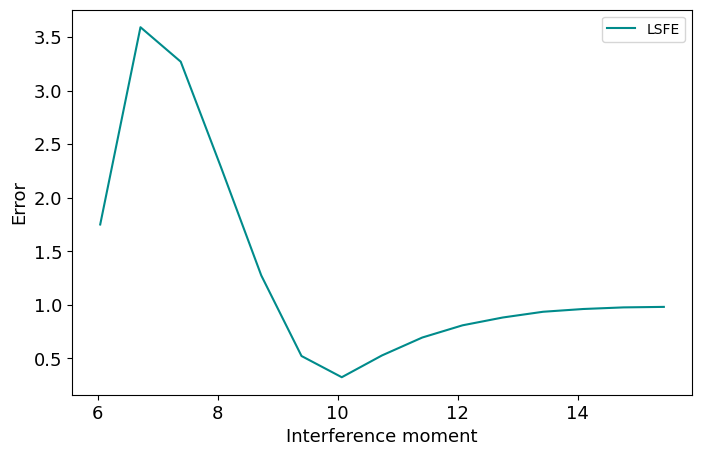

[7636.74259028 7122.85462622 6297.34897284 4173.17364278 3897.91450548
  399.36709267 1490.17203995  521.51621078  365.44590381   35.23361761
  283.65766308  159.2989612   181.22916974   43.15457545    8.33452114]


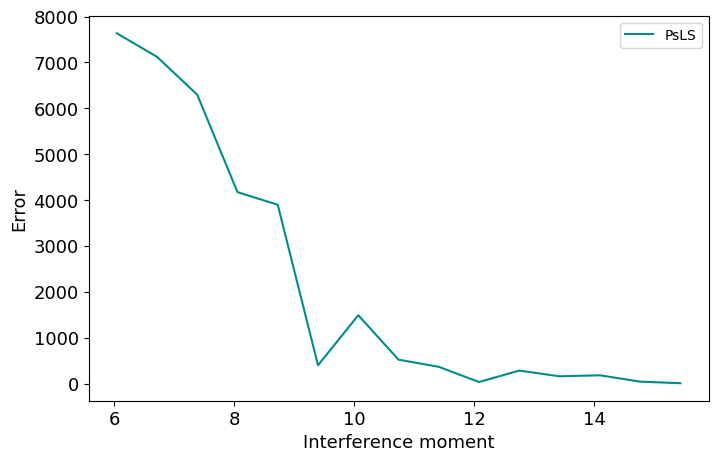

[1.39167955e+00 1.51568205e+00 1.72843506e+00 2.06892629e+00
 2.72298459e+00 3.98693447e+00 6.94184287e+00 1.28028944e+01
 2.82673570e+01 6.46808966e+01 1.57761980e+02 3.81547878e+02
 9.22643500e+02 1.99662857e+03 3.68639158e+03]


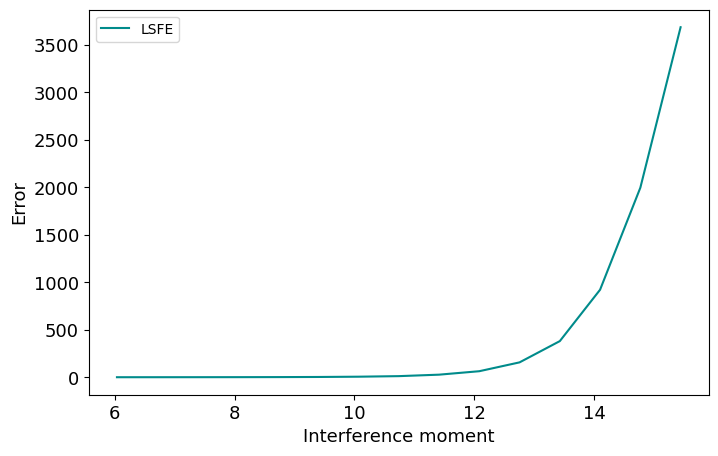

[  23.37341016   38.54798158   60.73051213  113.03277642  132.73089617
  212.65426821  161.31089329   10.53758349  611.63999901  855.06962458
 2918.76615005 8092.88766279 8092.88717887 4740.04664116 3729.65844906]


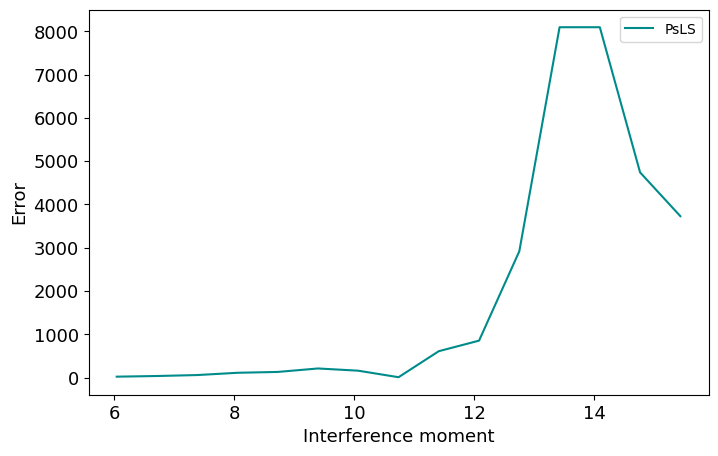

In [94]:
moments = np.array(moments)
error11 = np.array(error11)
error12 = np.array(error12)
error21 = np.array(error21)
error22 = np.array(error22)

fig=plt.figure(figsize=(8,5))
plt.xlabel("Interference moment",fontsize=13)
plt.ylabel("Error",fontsize=13) 
plt.plot(moments , error11, label="LSFE", color = "darkcyan")
print(error11)
plt.legend()
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
fig.savefig("lm1.png")
plt.show()

fig=plt.figure(figsize=(8,5))
plt.xlabel("Interference moment",fontsize=13)
plt.ylabel("Error",fontsize=13) 
plt.plot(moments , error12, label="PsLS", color = "darkcyan")
print(error12)
plt.legend()
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
fig.savefig("pm1.png")
plt.show()

fig=plt.figure(figsize=(8,5))
plt.xlabel("Interference moment",fontsize=13)
plt.ylabel("Error",fontsize=13) 
plt.plot(moments , error21, label="LSFE", color = "darkcyan")
print(error21)
plt.legend()
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
fig.savefig("lm2.png")
plt.show()

fig=plt.figure(figsize=(8,5))
plt.xlabel("Interference moment",fontsize=13)
plt.ylabel("Error",fontsize=13) 
plt.plot(moments , error22, label="PsLS", color = "darkcyan")
print(error22)
plt.legend()
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
fig.savefig("pm2.png")
plt.show()

4.026845637583893
50 
 (KstestResult(statistic=0.3, pvalue=0.13500350250095441), 418.28933055933055, -1.0941140461466055)
Time LSFE: 0.5590381622314453
LSFE 0.7500124945188616 9843.676772528821
(KstestResult(statistic=0.7333333333333333, pvalue=2.089059293829158e-39), 123.0019382566411, 0.9991174418446539)
Time PsLS: 0.06697607040405273
PsLSWithLSFE 1.2075187429027348 -1145757232.903458
(KstestResult(statistic=0.48, pvalue=5.145071127878014e-16), 2.5008121880117196e+20, -3.6482246784809505e+33)


 /Users/bianca/opt/anaconda3/lib/python3.8/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning:Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.


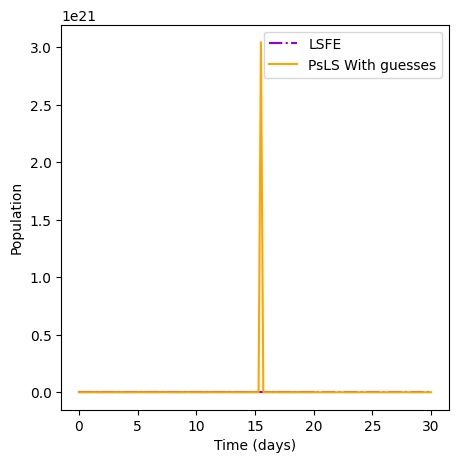

4.026845637583893
50 
 (KstestResult(statistic=0.525, pvalue=1.8234825805609493e-15), 2912.271507887069, 0.39332726528508577)
Time LSFE: 0.4161667823791504
LSFE 0.7499929252036939 9998.516631826744
(KstestResult(statistic=0.10666666666666667, pvalue=0.3617268879273219), 1.1833989006972638, 0.9999999183075831)
Time PsLS: 0.041976213455200195
PsLSWithLSFE 0.750911886692541 9976.880710522284
(KstestResult(statistic=0.56, pvalue=5.290396633242105e-22), 17.734552395136333, 0.9999816532186291)


 /Users/bianca/opt/anaconda3/lib/python3.8/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning:Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.


Time PsLS: 0.4120190143585205
PsLS -2.7463717052495806e-08 8.941558889652006e-05
(KstestResult(statistic=0.9533333333333334, pvalue=8.625999947841026e-76), 8092.332127452206, -2.820030408625254)


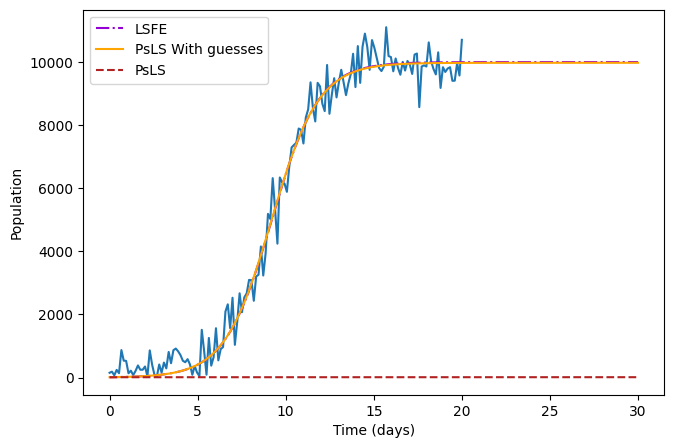

In [96]:
n = 150 #no of smaples
K = 10**4  # carrying capacity of E.coli Colony Forming Units(CFU)/g for feed codition
r = 0.75 # groth rate E.coli per day for feed casw
x0 = 10
# K = 10**5  # carrying capacity of E.coli Colony Forming Units(CFU)/g for feed codition
# r = 1.5 # groth rate E.coli per day for feed casw
t = np.linspace(0,20,n)
m = 30
np.random.seed(15)
yt = logisticSolutions(t,t[m])
noiseTrainingt = np.random.normal(0,500,150)
noisyYt = yt + noiseTrainingt
noisyYt[:50] = np.abs(noisyYt[:50]) + 5


plt.figure(figsize=(5,5))
plt.plot(t,noisyYt)

print(t[m])
start = time.time()
estimations = LSFELG(t[:m], nk, [0,t[m]], noisyYt[:m], noiseTrainingt[:m])
e1,e2 = sp.optimize.curve_fit(logisticEquation, t[:m], estimations, full_output = 1)[0]
end = time.time()
print("Time LSFE:", end-start)
print("LSFE",e1,e2)
predictions = predict(trainingT,e1,e2)
plt.plot(trainingT,predictions, label="LSFE", color = "darkviolet", ls="-.")
print(statis(trainingY,predictions,noiseTraining))

e1,e2 = PsLS(t[:m], noisyYt[:m], logisticEquation, 1, rbf.epanechnikov, [e1,e2])
print("PsLSWithLSFE",e1,e2)
predictions = predict(trainingT,e1,e2)
print(statis(trainingY,predictions,noiseTraining))
plt.plot(trainingT,predictions, label="PsLS With guesses", color = "orange")

plt.legend()
plt.xlabel("Time (days)")
plt.ylabel("Population")
plt.show()


# Secoind part

print(t[m])
plt.figure(figsize=(7.5,5))
plt.plot(t,noisyYt)
meanT = t[m:] - t[m]
meanY = noisyYt[m:] - noisyYt[m]
x0 = 10
start = time.time()
estimations = LSFELG(meanT, nk, [0,t[-1]], meanY, noiseTrainingt[m:])
e1,e2 = sp.optimize.curve_fit(logisticEquation, meanT, estimations, full_output = 1)[0]
end = time.time()
print("Time LSFE:", end-start)
print("LSFE",e1,e2)

x0 = 10
predictions = predict(trainingT,e1,e2)
plt.plot(trainingT,predictions, label="LSFE", color = "darkviolet", ls="-.")
print(statis(trainingY,predictions,noiseTraining))

x0 = yt[m]
e1,e2 = PsLS(t[m:],noisyYt[m:], logisticEquation, 1, rbf.epanechnikov, [e1,e2])
print("PsLSWithLSFE",e1,e2)
x0 = 10
# print("PsLS",e1,e2)
predictions = predict(trainingT,e1,e2)
print(statis(trainingY,predictions,noiseTraining))
plt.plot(trainingT,predictions, label="PsLS With guesses", color = "orange")


x0 = yt[m]
e1,e2 = PsLS(t[m:],noisyYt[m:], logisticEquation, 1, rbf.epanechnikov)
print("PsLS",e1,e2)
x0 = 10
predictions = predict(trainingT,e1,e2)
print(statis(trainingY,predictions,noiseTraining))
plt.plot(trainingT,predictions, label="PsLS", color="firebrick", ls="--")

plt.legend()
plt.xlabel("Time (days)")
plt.ylabel("Population")
plt.show()

50 
 (KstestResult(statistic=0.18333333333333332, pvalue=0.035223296929317895), 498.4337512968786, 0.9846869971812)
Time PsLS: 0.03967714309692383
PsLSWithLSFE 0.7485992666501158 10099.071218846711
50 
 (KstestResult(statistic=0.8666666666666667, pvalue=8.246509538996e-12), 3902.258156232683, -3.0759895058705817)
Time PsLS: 0.0628519058227539
50 
 (KstestResult(statistic=0.18333333333333332, pvalue=0.035223296929317895), 498.4337512968786, 0.9846869971812)
Time PsLS: 0.0651860237121582
PsLSWithLSFE 0.7485992666501158 10099.071218846711
50 
 (KstestResult(statistic=0.8, pvalue=8.466416460035895e-10), 1755.018160471014, -4.125810611284295)
Time PsLS: 0.015992164611816406
50 
 (KstestResult(statistic=0.18333333333333332, pvalue=0.035223296929317895), 498.4337512968786, 0.9846869971812)
Time PsLS: 0.04123806953430176
PsLSWithLSFE 0.7485992666501158 10099.071218846711
50 
 (KstestResult(statistic=0.5666666666666667, pvalue=8.737803591291227e-05), 869.2133653406197, -2.1180242868717416)
Time

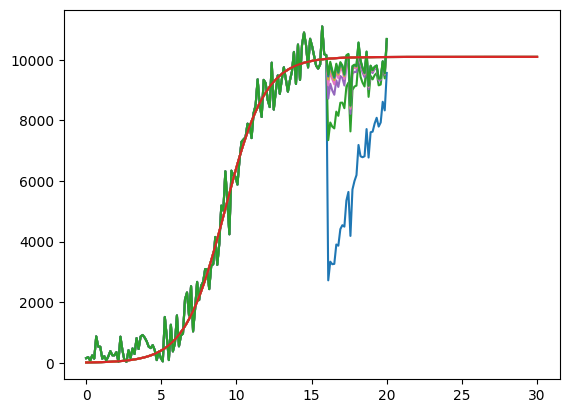

In [104]:
def logisticSolutions(t,m,d=6):
    
    dxdt = []
    for i in t: 
        t2 = i
        if t2 >= m :
            t2 -= m/d
        dxdt.append((K*10*np.exp(r*t2))/(K+10*(np.exp(r*t2)-1)))
    return dxdt

n = 150 #no of smaples
K = 10**4  # carrying capacity of E.coli Colony Forming Units(CFU)/g for feed codition
r = 0.75 # groth rate E.coli per day for feed casw
x0 = 10
t = np.linspace(0,20,n)
m = 120
d = 2

magnitude = []
error11 = []
error12 = []
error21 = []
error22 = []

while d <= 8:
    np.random.seed(15)
    yt = logisticSolutions(t,t[m],d)
    noiseTrainingt = np.random.normal(0,500,150)
    noisyYt = yt + noiseTrainingt
    noisyYt[:50] = np.abs(noisyYt[:50]) + 5
    magnitude.append(d)

    estimations = LSFELG(t[:m], nk, [0,t[m]], noisyYt[:m], noiseTrainingt[:m])
    e1,e2 = sp.optimize.curve_fit(logisticEquation, t[:m], estimations, full_output = 1)[0]
    predictions = predict(trainingT,e1,e2)
    error11.append(statis(trainingY,predictions,noiseTraining)[1])

    e1,e2 = PsLS(t[:m], noisyYt[:m], logisticEquation, 1, rbf.epanechnikov, [e1,e2])
    print("PsLSWithLSFE",e1,e2)
    predictions = predict(trainingT,e1,e2)
    error12.append(statis(trainingY,predictions,noiseTraining)[1])

    plt.plot(t, noisyYt)
    plt.plot(trainingT,predictions)
    
# Secoind part
    meanT = t[m:] - t[m]
    meanY = noisyYt[m:] - noisyYt[m]

    x0 = 10
    estimations = LSFELG(meanT, nk, [0,t[-1]], meanY, noiseTrainingt[m:])
    e1,e2 = sp.optimize.curve_fit(logisticEquation, meanT, estimations, full_output = 1)[0]
    predictions = predict(trainingT,e1,e2)
    error21.append(statis(trainingY,predictions,noiseTraining)[1])

    x0 = yt[m]
    e1,e2 = PsLS(t[m:],noisyYt[m:], logisticEquation, 1, rbf.epanechnikov, [e1,e2])
    x0 = 10
    predictions = predict(trainingT,e1,e2)
    error22.append(statis(trainingY,predictions,noiseTraining)[1])
    d += 1


[0.9793521 0.9793521 0.9793521 0.9793521 0.9793521 0.9793521 0.9793521]


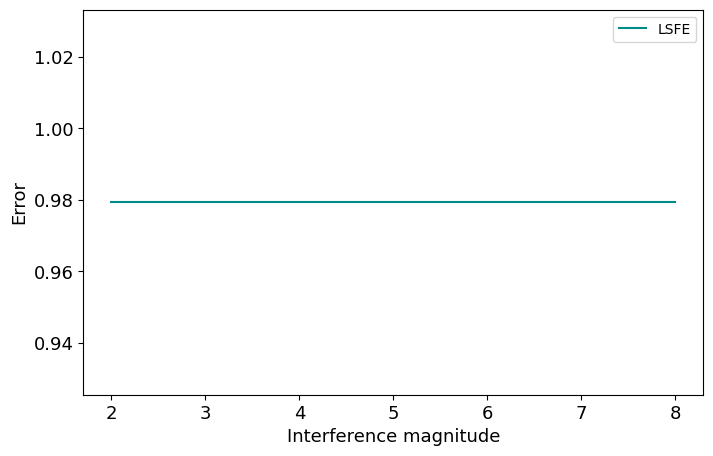

[75.71052093 75.71052093 75.71052093 75.71052093 75.71052093 75.71052093
 75.71052093]


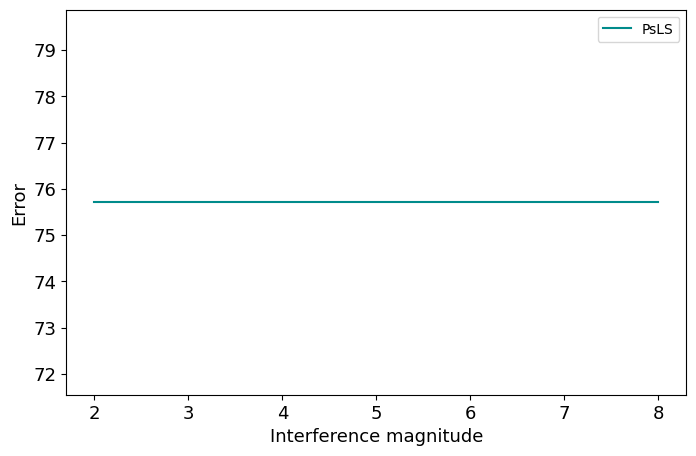

[5529.53877711 5529.53877711 5529.53877711 5529.53877711 5529.53877711
 5529.53877711 5529.53877711]


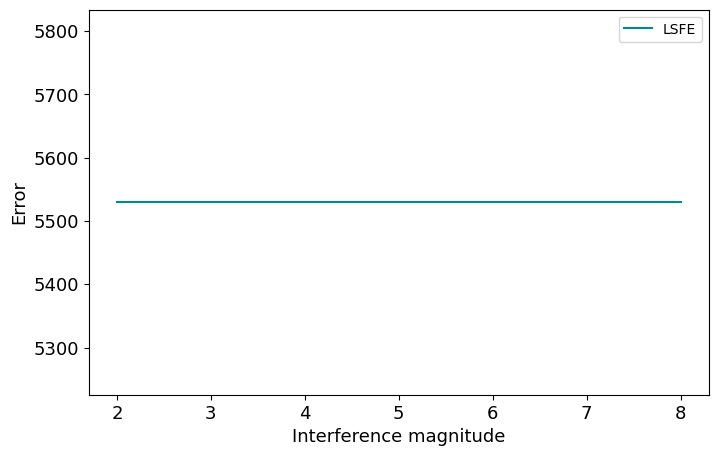

[ 756.98453024 2638.33297583 6336.48406186 8089.09362763 8091.33203727
 8091.81726073 8092.09658191]


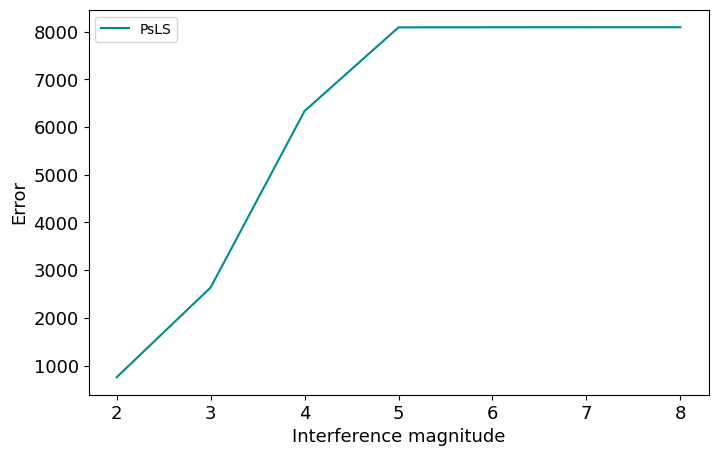

In [105]:
magnitude = np.array(magnitude)
error11 = np.array(error11)
error12 = np.array(error12)
error21 = np.array(error21)
error22 = np.array(error22)

fig=plt.figure(figsize=(8,5))
plt.xlabel("Interference magnitude",fontsize=13)
plt.ylabel("Error",fontsize=13) 
plt.plot(magnitude , error11, label="LSFE", color = "darkcyan")
print(error11)
plt.legend()
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
fig.savefig("lm2.png")
plt.show()

fig=plt.figure(figsize=(8,5))
plt.xlabel("Interference magnitude",fontsize=13)
plt.ylabel("Error",fontsize=13) 
plt.plot(magnitude , error12, label="PsLS", color = "darkcyan")
print(error12)
plt.legend()
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
fig.savefig("lm2.png")
plt.show()

fig=plt.figure(figsize=(8,5))
plt.xlabel("Interference magnitude",fontsize=13)
plt.ylabel("Error",fontsize=13) 
plt.plot(magnitude , error21, label="LSFE", color = "darkcyan")
print(error21)
plt.legend()
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
fig.savefig("lm2.png")
plt.show()

fig=plt.figure(figsize=(8,5))
plt.xlabel("Interference magnitude",fontsize=13)
plt.ylabel("Error",fontsize=13) 
plt.plot(magnitude , error22, label="PsLS", color = "darkcyan")
print(error22)
plt.legend()
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
fig.savefig("120magnitude.png")
plt.show()

50 
 (KstestResult(statistic=0.7066666666666667, pvalue=2.8630071255574174e-36), 6891.600862964151, -1423797.3898915427)
Time LSFE: 0.4027431011199951
LSFE 0.7499862405862044 9998.859387898834
(KstestResult(statistic=0.8733333333333333, pvalue=1.1387380418559837e-59), 2629.03849329856, 0.5968066949628256)
Time PsLS: 0.03999185562133789
PsLSWithLSFE 0.7525012782409146 9966.389234726492
(KstestResult(statistic=0.9466666666666667, pvalue=3.1592724808967757e-74), 2613.3304550657913, 0.6016103183929745)
Time PsLS: 0.09511780738830566
PsLS 0.7525016226012606 9966.38648832733
(KstestResult(statistic=0.9466666666666667, pvalue=3.1592724808967757e-74), 2613.3281101137013, 0.6016110333460304)


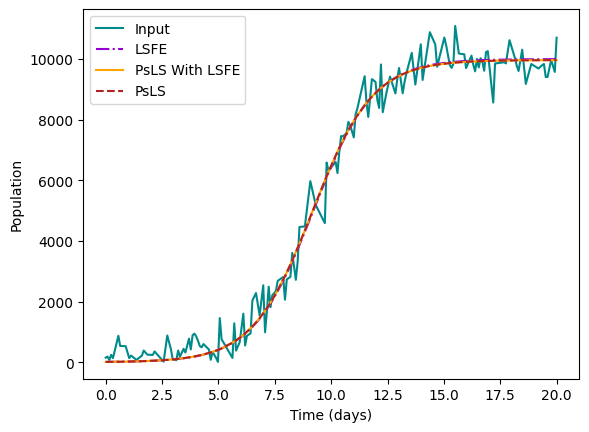

In [124]:

n = 250 #no of smaples
K = 10**4  # carrying capacity of E.coli Colony Forming Units(CFU)/g for feed codition
r = 0.75 # groth rate E.coli per day for feed casw
x0 = 10
t = np.linspace(0,20,n)
m = 100
y = logisticSolutions(t,t[m])

np.random.seed(15)
trainingTt, testingTt = train_test_split(t, test_size= 100, train_size= 150, random_state=42)

trainingTt = np.sort(trainingTt)
trainingYt = np.empty(150)

testingTt = np.sort(testingTt)
testingYt = np.empty(100)
i = 0
j = 0
for l in range(len(t)):
    if(trainingTt[i] == t[l]):
        trainingYt[i] = y[l]
        i += 1
    else:
        testingYt[j] = y[l]
        j += 1

nk =15      

noiseTrainingt = np.random.normal(0,500,150)
noisyYt = trainingYt + noiseTrainingt
noisyYt[:50] = np.abs(noisyYt[:50]) + 5


plt.plot(trainingTt,noisyYt, label="Input",color="darkcyan")
start = time.time()
estimations = LSFELG(trainingTt, nk, [0,20], trainingTt, noiseTrainingt)
e1,e2 = sp.optimize.curve_fit(logisticEquation, trainingTt , estimations, full_output = 1)[0]
end = time.time()
print("Time LSFE:", end-start)
print("LSFE",e1,e2)
predictions1 = predict(trainingTt,e1,e2)
plt.plot(trainingTt,predictions1, label="LSFE", color = "darkviolet", ls="-.")
print(statis(trainingY,predictions1,noiseTraining))


e1,e2 = PsLS(trainingTt, noisyYt, logisticEquation, 1, rbf.epanechnikov, [e1,e2])
print("PsLSWithLSFE",e1,e2)
predictions = logisticEquation(trainingTt,e1,e2)
plt.plot(trainingTt,predictions, label="PsLS With LSFE", color = "orange")
print(statis(trainingY,predictions,noiseTraining))

e1,e2 = PsLS(trainingTt, noisyYt, logisticEquation,1, rbf.epanechnikov)
print("PsLS",e1,e2)
predictions = predict(trainingTt,e1,e2)
print(statis(trainingY,predictions,noiseTraining))
plt.plot(trainingTt,predictions, label="PsLS",color="firebrick", ls="--")

plt.legend()
plt.xlabel("Time (days)")
plt.ylabel("Population")
plt.show()


### Increase 

50 
 (KstestResult(statistic=0.16, pvalue=0.04283167282545192), 483.971541321704, 0.9869321076453184)
LSFE 0.7499738199074345 9999.192780240504
(KstestResult(statistic=0.8733333333333333, pvalue=1.1387380418559837e-59), 2629.09619956743, 0.5967889949278703)
Time PsLS: 0.040657997131347656
PsLSWithLSFE 0.7526835557680291 9970.942395608989
(KstestResult(statistic=0.9466666666666667, pvalue=3.1592724808967757e-74), 2611.348143587447, 0.6022144769034199)
Time PsLS: 0.08045721054077148
PsLS 0.7526839158297446 9970.939561790956
(KstestResult(statistic=0.9466666666666667, pvalue=3.1592724808967757e-74), 2611.345685328165, 0.6022152258341945)


Text(0, 0.5, 'Population')

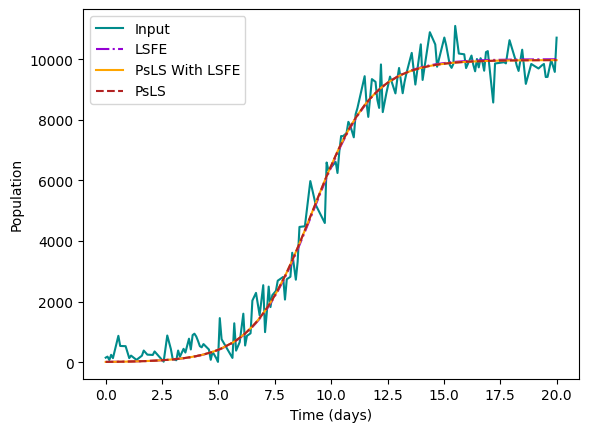

In [125]:
n = 250 #no of smaples
K = 10**4  # carrying capacity of E.coli Colony Forming Units(CFU)/g for feed codition
r = 0.75 # groth rate E.coli per day for feed casw
x0 = 10
t = np.linspace(0,20,n)
m = 10
y = logisticSolutions(t,m)

np.random.seed(15)
trainingTt, testingTt = train_test_split(t, test_size= 100, train_size= 150, random_state=42)

trainingTt = np.sort(trainingTt)
trainingYt = np.empty(150)

testingTt = np.sort(testingTt)
testingYt = np.empty(100)
i = 0
j = 0
for l in range(len(t)):
    if(trainingTt[i] == t[l]):
        trainingYt[i] = y[l]
        i += 1
    else:
        testingYt[j] = y[l]
        j += 1

nk =15      

noiseTrainingt = np.random.normal(0,500,150)

noisyYt = trainingYt + noiseTrainingt
noisyYt[:300] = np.abs(noisyYt[:300]) + 5

plt.plot(trainingTt,noisyYt, label="Input",color="darkcyan")

estimations = LSFELG(trainingTt, nk, [0,40], noisyYt, noiseTrainingt)
e1,e2 = sp.optimize.curve_fit(logisticEquation, trainingTt , estimations, full_output = 1)[0]
print("LSFE",e1,e2)
predictions1 = predict(trainingTt,e1,e2)
plt.plot(trainingTt,predictions1, label="LSFE", color = "darkviolet", ls="-.")
print(statis(trainingY,predictions1,noiseTraining))


e1,e2 = PsLS(trainingTt, noisyYt, logisticEquation, 1, rbf.epanechnikov, [e1,e2])
print("PsLSWithLSFE",e1,e2)
predictions = logisticEquation(trainingTt,e1,e2)
plt.plot(trainingTt,predictions, label="PsLS With LSFE", color = "orange")
print(statis(trainingY,predictions,noiseTraining))

e1,e2 = PsLS(trainingTt, noisyYt, logisticEquation,1, rbf.epanechnikov)
print("PsLS",e1,e2)
predictions = predict(trainingTt,e1,e2)
print(statis(trainingY,predictions,noiseTraining))
plt.plot(trainingTt,predictions, label="PsLS",color="firebrick", ls="--")

plt.legend()
plt.xlabel("Time (days)")
plt.ylabel("Population")


## 2 Tinkerings

In [123]:
def logisticSolutions2(t,m):
    
    dxdt = []
    for i in t: 
        t2 = i
        if t2 >= m[0] :
            t2 -= m[0]/6
        if t2 >= m[1] :
            t2 -= m[1]/6
        dxdt.append((K*10*np.exp(r*t2))/(K+10*(np.exp(r*t2)-1)))
    return dxdt


50 
 (KstestResult(statistic=0.7777777777777778, pvalue=0.006293706293706292), 445.3067757953948, -1.4165089037534107)
Time PsLS: 0.06254100799560547
PsLSWithLSFE 3.924280731782681 -8737.948261457517


 /Users/bianca/opt/anaconda3/lib/python3.8/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning:Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.


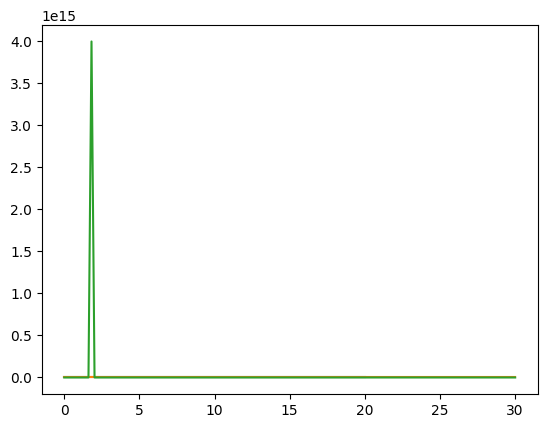

50 
 (KstestResult(statistic=0.2857142857142857, pvalue=0.9627039627039629), 109.0468592093885, 0.004572346966192908)
0.8150243247272204 621263.026774174
Time PsLS: 0.02174520492553711
3.501092943746676 -410345395992.40265


 /Users/bianca/opt/anaconda3/lib/python3.8/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning:Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
 /Users/bianca/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning:Covariance of the parameters could not be estimated


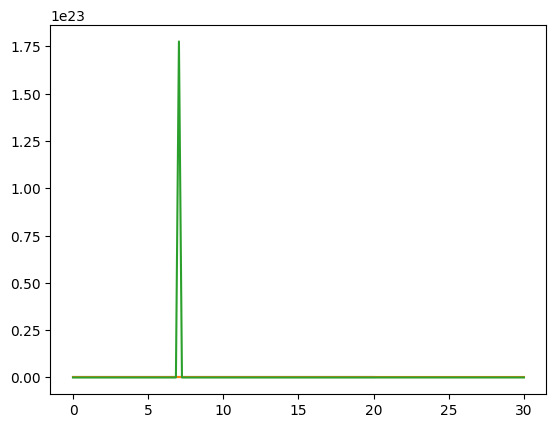

50 
 (KstestResult(statistic=0.3656716417910448, pvalue=2.3283285582586802e-08), 1084.890845932605, 0.9220028160845417)
Time PsLS: 0.03770804405212402


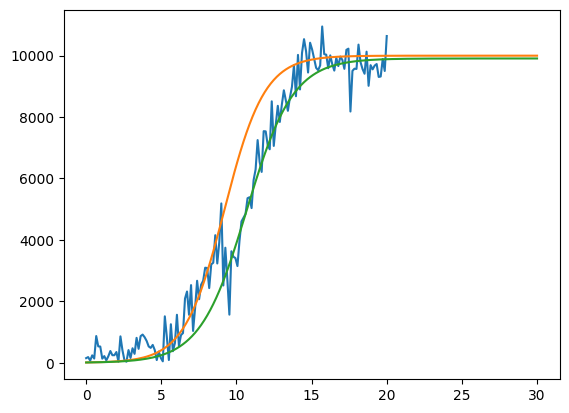

In [126]:
n = 150 #no of smaples
K = 10**4  # carrying capacity of E.coli Colony Forming Units(CFU)/g for feed codition
r = 0.75 # groth rate E.coli per day for feed casw
x0 = 10
t = np.linspace(0,20,n)
m = np.array([9,16])



moments = []
error11 = []
error12 = []
error21 = []
error22 = []
error31 = []
error32 = []

# while m[0] < 10:
np.random.seed(15)
yt = logisticSolutions2(t,m)
noiseTrainingt = np.random.normal(0,500,150)
noisyYt = yt + noiseTrainingt
noisyYt[:50] = np.abs(noisyYt[:50]) + 5
moments.append(t[m[0]])

plt.plot(t,noisyYt)
estimations = LSFELG(t[:m[0]], nk, [0,t[m[0]]], noisyYt[:m[0]], noiseTrainingt[:m[0]])
e1,e2 = sp.optimize.curve_fit(logisticEquation, t[:m[0]], estimations, full_output = 1)[0]
predictions = predict(trainingT,e1,e2)
error11.append(statis(trainingY,predictions,noiseTraining)[1])
plt.plot(trainingT,predictions)
e1,e2 = PsLS(t[:m[0]], noisyYt[:m[0]], logisticEquation, 1, rbf.epanechnikov, [e1,e2])
print("PsLSWithLSFE",e1,e2)
predictions = predict(trainingT,e1,e2)
error12.append(statis(trainingY,predictions,noiseTraining)[1])
plt.plot(trainingT,predictions)
plt.show()

#  Middle part
plt.plot(t,noisyYt)
meanT = t[m[0]:m[1]] - t[m[0]]
meanY = noisyYt[m[0]:m[1]] - noisyYt[m[0]]
estimations = LSFELG(meanT, nk, [0,t[-1]], meanY, noiseTrainingt[m[0]:m[1]])
e1,e2 = sp.optimize.curve_fit(logisticEquation, meanT, estimations, full_output = 1)[0]
print(e1,e2)
predictions = predict(trainingT,e1,e2)
error21.append(statis(trainingY,predictions,noiseTraining)[1])
plt.plot(trainingT,predictions)
x0 = yt[m[0]]
e1,e2 = PsLS(t[m[0]:m[1]], noisyYt[m[0]:m[1]], logisticEquation, 1, rbf.epanechnikov, [e1,e2])
print(e1,e2)
x0 = 10
predictions = predict(trainingT,e1,e2)
error22.append(statis(trainingY,predictions,noiseTraining)[1])
plt.plot(trainingT,predictions)
plt.show()

# Third part
plt.plot(t,noisyYt)
meanT = t[m[1]:] - t[m[1]]
meanY = noisyYt[m[1]:] - noisyYt[m[1]]

x0 = 10
estimations = LSFELG(meanT, nk, [0,t[-1]], meanY, noiseTrainingt[m[1]:])
e1,e2 = sp.optimize.curve_fit(logisticEquation, meanT, estimations, full_output = 1)[0]
predictions = predict(trainingT,e1,e2)
error31.append(statis(trainingY,predictions,noiseTraining)[1])
plt.plot(trainingT,predictions)
x0 = yt[m[1]]
e1,e2 = PsLS(t[m[1]:],noisyYt[m[1]:], logisticEquation, 1, rbf.epanechnikov, [e1,e2])
x0 = 10
predictions = predict(trainingT,e1,e2)
error32.append(statis(trainingY,predictions,noiseTraining)[1])
plt.plot(trainingT,predictions)

In [ ]:
moments = np.array(moments)
error11 = np.array(error11)
error12 = np.array(error12)
error21 = np.array(error21)
error22 = np.array(error22)
error31 = np.array(error31)
error32 = np.array(error32)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.xlabel("Interference moment")
plt.ylabel("Error") 
plt.plot(moments , error11, label="LSFE", color = "darkcyan")
print(error11)
plt.legend()

plt.subplot(1,2,2)
plt.xlabel("Interference moment")
plt.ylabel("Error") 
plt.plot(moments , error12, label="PsLS", color = "darkcyan")
print(error12)
plt.legend()

plt.show()

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.xlabel("Interference moment")
plt.ylabel("Error") 
plt.plot(moments , error21, label="LSFE", color = "darkcyan")
print(error21)
plt.legend()

plt.subplot(1,2,2)
plt.xlabel("Interference moment")
plt.ylabel("Error") 
plt.plot(moments , error22, label="PsLS", color = "darkcyan")
print(error22)
plt.legend()

plt.show()

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.xlabel("Interference moment")
plt.ylabel("Error") 
plt.plot(moments , error31, label="LSFE", color = "darkcyan")
print(error31)
plt.legend()

plt.subplot(1,2,2)
plt.xlabel("Interference moment")
plt.ylabel("Error") 
plt.plot(moments , error32, label="PsLS", color = "darkcyan")
print(error32)
plt.legend()

50 
 (KstestResult(statistic=0.16, pvalue=0.04283167282545192), 485.0938832118489, 0.986755883864407)
Time LSFE: 0.4027431011199951
LSFE 0.749983409289645 9998.900497903986
(KstestResult(statistic=0.09333333333333334, pvalue=0.5321869291503776), 0.9095002857361506, 0.999999951746913)
Time PsLS: 0.03810691833496094
PsLSWithLSFE 0.7518467630325515 9969.557897504455
(KstestResult(statistic=0.58, pvalue=1.1050890820486825e-23), 24.637436390013335, 0.9999645912615177)
Time PsLS: 0.08532118797302246
PsLS 0.7518468184953441 9969.557458256339
(KstestResult(statistic=0.58, pvalue=1.1050890820486825e-23), 24.63787186649545, 0.9999645900097796)


Text(0, 0.5, 'Population')

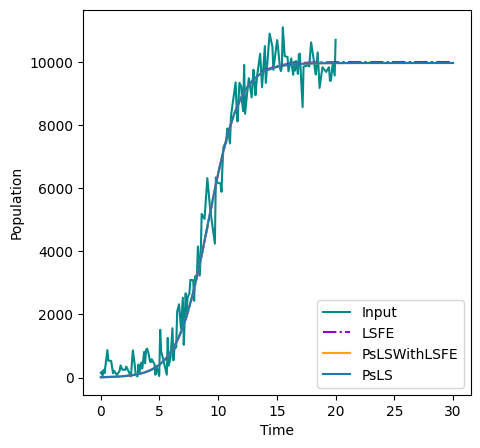

In [129]:
n = 150 #no of smaples
K = 10**4  # carrying capacity of E.coli Colony Forming Units(CFU)/g for feed codition
r = 0.75 # groth rate E.coli per day for feed casw
x0 = 10
t = np.linspace(0,20,n)
m = np.array([8,15])

np.random.seed(15)
yt = logisticSolutions(t,m)
noiseTrainingt = np.random.normal(0,500,150)
noisyYt = yt + noiseTrainingt
noisyYt[:50] = np.abs(noisyYt[:50]) + 5

plt.figure(figsize=(5,5))
plt.plot(trainingTt,noisyYt, label="Input", color="darkcyan")
# print("Original",K,r)
nk=10
predictions = LSFELG(t, nk, [0,20], noisyYt, noiseTrainingt)
e1,e2 = sp.optimize.curve_fit(logisticEquation, t , predictions, full_output = 1)[0]
print("Time LSFE:", end- start)
print("LSFE", e1,e2)
predictions = logisticEquation(trainingT,e1,e2)
plt.plot(trainingT,predictions, label="LSFE", color = "darkviolet", ls="-.")
print(statis(trainingY,predictions,noiseTraining))


e1,e2 = PsLS(t, noisyYt, logisticEquation,1, rbf.epanechnikov, [e1,e2])
print("PsLSWithLSFE",e1,e2)
predictions = predict(trainingT,e1,e2)
plt.plot(trainingT,predictions, label="PsLSWithLSFE", color = "orange")
print(statis(trainingY,predictions,noiseTraining))

plt.legend()
plt.xlabel("Time")
plt.ylabel("Population")

e1,e2 = PsLS(t, noisyYt, logisticEquation,1, rbf.epanechnikov)
print("PsLS",e1,e2)
predictions = predict(trainingT,e1,e2)
print(statis(trainingY,predictions,noiseTraining))
plt.plot(trainingT,predictions, label="PsLS")

plt.legend()
plt.xlabel("Time")
plt.ylabel("Population")
